<a href="https://colab.research.google.com/github/Chinmaya-3141/Capstone-Project/blob/main/Capstone_Object_Detection_Debugged_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Detection using Pytorch Faster RCNN Resnet-50-FPN model**

## Install, import necessary packages, global variables

In [1]:
# Mount Drive to import Data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%time
!pip install torchinfo -qq

CPU times: user 32.7 ms, sys: 12 ms, total: 44.7 ms
Wall time: 4.73 s


In [3]:
%%time
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' -qq

  Preparing metadata (setup.py) ... done
CPU times: user 93.4 ms, sys: 15.9 ms, total: 109 ms
Wall time: 13.1 s


In [4]:
%%time
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 322035, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 322035 (delta 5), reused 8 (delta 1), pack-reused 322014
Receiving objects: 100% (322035/322035), 651.34 MiB | 23.53 MiB/s, done.
Resolving deltas: 100% (296034/296034), done.
CPU times: user 689 ms, sys: 69.9 ms, total: 759 ms
Wall time: 1min 20s


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 

In [6]:
import os
import random
import math
import sys
import time
import tqdm
from tqdm import trange
import shutil
from skimage import io
import cv2
from albumentations.pytorch import ToTensorV2
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip,
                            Normalize,Flip, Compose, GaussNoise)
# import albumentations as A

In [8]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn as fasterrcnn
from torch.utils.data import DataLoader, Dataset
from torchvision import utils
from torchvision import transforms
from torchinfo import summary as tisum
from torch.optim import AdamW, RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR

# from engine import train_one_epoch, evaluate
# from torchvision.models.detection import retinanet_resnet50_fpn as retinanet
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
# from torch.utils.data.sampler import SequentialSampler
# from torchvision.models.detection.transform import GeneralizedRCNNTransform as g_trans

In [9]:
from engine import train_one_epoch, evaluate
import utils

In [10]:
# To improve reproducibility

def seed_everything(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [11]:
seed_everything(42)

In [12]:
print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


In [13]:
batchsize = 16
channels = 3
dimension = 640
learning_rate = 0.005
weight_decay = 0.0005

## Import, Explore Data

In [14]:
csv_path = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/For Object Detection/Object_detection_640_corrected.csv'
train_dir = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/For Object Detection/Combined_640_images of Covid and Pneumonia _for FasterRCNN'

In [15]:
df = pd.read_csv(csv_path)
df.head(16)

filename  width  height                  bbox  label  xmin  ymin  \
0   COVID-100.png    640     640  [204, 192, 478, 530]  covid   204   192   
1   COVID-101.png    640     640  [196, 140, 484, 444]  covid   196   140   
2   COVID-103.png    640     640  [166, 140, 462, 482]  covid   166   140   
3   COVID-104.png    640     640  [192, 158, 490, 508]  covid   192   158   
4   COVID-105.png    640     640  [152, 122, 432, 516]  covid   152   122   
5   COVID-106.png    640     640  [182, 134, 436, 496]  covid   182   134   
6   COVID-107.png    640     640  [198, 138, 470, 464]  covid   198   138   
7   COVID-108.png    640     640  [234, 232, 474, 514]  covid   234   232   
8   COVID-109.png    640     640  [200, 162, 458, 514]  covid   200   162   
9    COVID-10.png    640     640  [190, 180, 492, 504]  covid   190   180   
10  COVID-110.png    640     640  [162, 230, 410, 590]  covid   162   230   
11  COVID-111.png    640     640  [186, 128, 442, 518]  covid   186   128   
12  COVID-112.png    640     640  [160, 192, 486, 504]  covid   160   192   
13  COVID-113.png    640     640  [242, 180, 426, 402]  covid   242   180   
14  COVID-113.png    640     640  [428, 356, 470, 406]  covid   428   356   
15  COVID-114.png    640     640  [214, 174, 412, 432]  covid   214   174   

    xmax  ymax  box_w  box_h  
0    478   530    274    338  
1    484   444    288    304  
2    462   482    296    342  
3    490   508    298    350  
4    432   516    280    394  
5    436   496    254    362  
6    470   464    272    326  
7    474   514    240    282  
8    458   514    258    352  
9    492   504    302    324  
10   410   590    248    360  
11   442   518    256    390  
12   486   504    326    312  
13   426   402    184    222  
14   470   406     42     50  
15   412   432    198    258

In [16]:
# Checking the data

print(f'Total number of train images is {len(os.listdir(train_dir))}')
print(f'shape of dataframe is {df.shape}')
print(f'Number of images in dataframe is {len(np.unique(df["filename"]))}')
print(f'Number of train images with no bounding boxes {len(os.listdir(train_dir)) - len(np.unique(df["filename"]))}')

Total number of train images is 925
shape of dataframe is (2601, 11)
Number of images in dataframe is 925
Number of train images with no bounding boxes 0


In [17]:
# If images without bounding boxes exist, list them

for var in os.listdir(train_dir):
  if var not in np.unique(df["filename"]):
    print(var)

In [18]:
df['label'].unique()

array(['covid', 'pneumonia'], dtype=object)

In [19]:
# Label encoding classes

enc = preprocessing.LabelEncoder()
df['enc_labels'] = enc.fit_transform(df['label'])   # label encode classes 0-1
df['enc_labels'] = np.stack(df['enc_labels'][i]+1 for i in range(len(df['enc_labels'])))    # label encode classes 1-2

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [20]:
classes = df[['label','enc_labels']].value_counts()
classes

label      enc_labels
pneumonia  2             1492
covid      1             1109
dtype: int64

In [21]:
# make dictionary for class objects so we can call objects by their keys.
classes= {0:'background', 1:'covid',2:'pneumonia'}

In [22]:
df.head()

filename  width  height                  bbox  label  xmin  ymin  \
0  COVID-100.png    640     640  [204, 192, 478, 530]  covid   204   192   
1  COVID-101.png    640     640  [196, 140, 484, 444]  covid   196   140   
2  COVID-103.png    640     640  [166, 140, 462, 482]  covid   166   140   
3  COVID-104.png    640     640  [192, 158, 490, 508]  covid   192   158   
4  COVID-105.png    640     640  [152, 122, 432, 516]  covid   152   122   

   xmax  ymax  box_w  box_h  enc_labels  
0   478   530    274    338           1  
1   484   444    288    304           1  
2   462   482    296    342           1  
3   490   508    298    350           1  
4   432   516    280    394           1

## Stratified sampling

In [23]:
df['filename'].nunique()

925

In [24]:
# Split the data in roughly equal proportions of each class into train and test in given ratio (80-20 usually).

def stratified_sampling(dataframe, proportion, column_name, filename):
    # Group the dataframe by the column and filename to split based on
    grouped_dataframe = dataframe.groupby([column_name, filename])
    
    # Initialize empty dataframes for the training and validation sets
    train_dataframe = pd.DataFrame()
    val_dataframe = pd.DataFrame()
    
    # Loop through each group and add the entire group to either the training or validation dataframe,
    # depending on a randomly generated value for that group
    for _, group in grouped_dataframe:
        if random.random() >= proportion: # Stochastic element introduced here
            val_dataframe = pd.concat([val_dataframe, group])
        else:
            train_dataframe = pd.concat([train_dataframe, group])
    
    # Reset the index of the dataframes
    train_dataframe = train_dataframe.reset_index(drop=True)
    val_dataframe = val_dataframe.reset_index(drop=True)
    
    return train_dataframe, val_dataframe


In [25]:
# Count the number of images for covid and pneumonia in split dataframe

def count_unique_filenames(df):
    # Filter the DataFrame to only include rows with "covid" or "pneumonia" labels
    covid_pneumonia_df = df[df['label'].isin(['covid', 'pneumonia'])]

    # Count the number of unique filenames with "covid" and "pneumonia" labels separately
    covid_filenames = covid_pneumonia_df[covid_pneumonia_df['label'] == 'covid']['filename'].nunique()
    pneumonia_filenames = covid_pneumonia_df[covid_pneumonia_df['label'] == 'pneumonia']['filename'].nunique()

    # Print output
    print(f"Unique filenames with Covid label:", covid_filenames)
    print(f"Unique filenames with Pneumonia label:", pneumonia_filenames)

    return covid_filenames, pneumonia_filenames

In [26]:
# Split the dataframe and images

train, val = stratified_sampling(df,0.8,'label','filename')

In [27]:
# Check if any filenames coincide

for i in train['filename']:
  if(i in val['filename']):
    print(i)

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    2042 non-null   object
 1   width       2042 non-null   int64 
 2   height      2042 non-null   int64 
 3   bbox        2042 non-null   object
 4   label       2042 non-null   object
 5   xmin        2042 non-null   int64 
 6   ymin        2042 non-null   int64 
 7   xmax        2042 non-null   int64 
 8   ymax        2042 non-null   int64 
 9   box_w       2042 non-null   int64 
 10  box_h       2042 non-null   int64 
 11  enc_labels  2042 non-null   int64 
dtypes: int64(9), object(3)
memory usage: 191.6+ KB


In [29]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    559 non-null    object
 1   width       559 non-null    int64 
 2   height      559 non-null    int64 
 3   bbox        559 non-null    object
 4   label       559 non-null    object
 5   xmin        559 non-null    int64 
 6   ymin        559 non-null    int64 
 7   xmax        559 non-null    int64 
 8   ymax        559 non-null    int64 
 9   box_w       559 non-null    int64 
 10  box_h       559 non-null    int64 
 11  enc_labels  559 non-null    int64 
dtypes: int64(9), object(3)
memory usage: 52.5+ KB


In [30]:
cf_total,pf_total = count_unique_filenames(df)

Unique filenames with Covid label: 479
Unique filenames with Pneumonia label: 446


In [31]:
cf_train, pf_train = count_unique_filenames(train)

Unique filenames with Covid label: 374
Unique filenames with Pneumonia label: 362


In [32]:
cf_val, pf_val = count_unique_filenames(val)

Unique filenames with Covid label: 105
Unique filenames with Pneumonia label: 84


In [33]:
print(f"Covid (fraction of total data): {round((cf_total/(cf_total + pf_total))*100,3)}%")
print(f"Pneumonia (fraction of total data): {round((pf_total/(cf_total + pf_total))*100,3)}%")

Covid (fraction of total data): 51.784%
Pneumonia (fraction of total data): 48.216%


In [34]:
print(f"Covid Train (fraction of covid): {round((cf_train/cf_total)*100,3)}%, Pneumonia Train (fraction of pneumonia): {round((pf_train/pf_total)*100,3)}%")
print(f"Covid Train (fraction of train): {round((cf_train/(cf_train + pf_train))*100,3)}%, Pneumonia Train (fraction of train): {round((pf_train/(cf_train+pf_train))*100,3)}%")

Covid Train (fraction of covid): 78.079%, Pneumonia Train (fraction of pneumonia): 81.166%
Covid Train (fraction of train): 50.815%, Pneumonia Train (fraction of train): 49.185%


In [35]:
print(f"Covid Test(fraction of covid): {round((cf_val/cf_total)*100,3)}%, Pneumonia Test (fraction of pneumonia): {round((pf_val/pf_total)*100,3)}%")
print(f"Covid Test (fraction of validation): {round((cf_val/(cf_val + pf_val))*100,3)}%, Pneumonia Test (fraction of validation): {round((pf_val/(cf_val+pf_val))*100,3)}%")

Covid Test(fraction of covid): 21.921%, Pneumonia Test (fraction of pneumonia): 18.834%
Covid Test (fraction of validation): 55.556%, Pneumonia Test (fraction of validation): 44.444%


In [36]:
A = df[df['filename']== 'COVID-113.png']['label'].values
A

array(['covid', 'covid'], dtype=object)

## Transforms, Custom DatasetClass, Dataloader

In [37]:
def get_transform():
    list_transforms = []
    # converts the input image, which should be a PIL image, into a PyTorch Tensor
    list_transforms.append(transforms.ToTensor())
    
    #keeping space for augmentations in future
    
    return transforms.Compose(list_transforms)

**Getitem returns for EACH image:**

1.   **image** - a PIL image of size (H,W) 

    for ResNet50 FPN image should be scaled

2.   **target** - a dictionary containing the following fields

    1. ***Boxes*** as FloatTensor of dimensions - (N,4) 
      
      here, N = number of bounding boxs within an image and the 4 columns include [x_min, y_min, x_max, y_max]
    2. ***Labels*** as Int64Tensor of dimension - N

    3. ***Area*** as Int64Tensor of dimension - N

    4. ***Iscrowd*** as UInt8Tensor of dimension - N

3. (removed) **image_id** - Name of the image


In [38]:
class XrayData(Dataset):
    def __init__(self,input_df,input_dir,transforms=None):
        super().__init__()
        self.df=input_df    
        self.list_images = list(self.df['filename'].unique())
        self.image_dir=input_dir
        self.transforms = transforms
        self.label_mapping = {0: "background", 1: "covid", 2: "pneumonia"}

    def __len__(self):
        return len(self.df['filename'].unique())

    def get_label_mapping(self):
        return self.label_mapping

    def __getitem__(self,idx):
                
        cols_to_be_selected =['xmin','ymin','xmax','ymax']
        img_id = self.list_images[idx]
        bboxes_array = np.array(self.df.loc[self.df['filename']==img_id,cols_to_be_selected])
        boxes = torch.tensor(bboxes_array, dtype=torch.float32)
        
        num_boxes = self.df.loc[self.df['filename']==img_id].shape[0]
        label = self.df[self.df['filename']== img_id]['enc_labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)

        area = torch.tensor(np.array((self.df['xmax']-self.df['xmin'])*(self.df['ymax']-self.df['ymin'])), dtype=torch.int64)

        iscrowd = torch.zeros(num_boxes, dtype=torch.uint8)
        
        # Combining everything
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
                
        # img = cv2.imread(os.path.join(self.image_dir, img_id), 0)  # 0 for grayscale
        img = cv2.imread(self.image_dir+'/'+img_id, cv2.IMREAD_COLOR)
        img_col = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_scaled = img_col / 255.0
        img_final = img_scaled

        if self.transforms is not None:
            img_final = self.transforms(img_final)
                
        return img_final, target

In [39]:
train_dataset = XrayData(train,train_dir,get_transform())
val_dataset = XrayData(val,train_dir,get_transform())

In [40]:
print(f'Length of train data {len(train_dataset)}')
print(f'Length of validation data {len(val_dataset)}')

Length of train data 736
Length of validation data 189


In [41]:
# batching
def collate_fn(batch):
    return tuple(zip(*batch))

In [42]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_dataset,
    batch_size=batchsize,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

In [43]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx) # Has (image, target, image_id) for idx
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy() # target boxes coordinates to numpy
    sample = out[1]['labels'].numpy()
    print(data.label_mapping)
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    for idx, i in enumerate(sample):
        label = data.label_mapping[i]
        x, y = int(bb[idx][0]), int(bb[idx][1])
        cv2.putText(image, label, (x, y-5), cv2.FONT_HERSHEY_COMPLEX, 0.7, (220,0,0), 1, cv2.LINE_AA)  

    plt.figure(figsize=(10,10))
    plt.imshow(image)

In [44]:
# train_dataset[124]

{0: 'background', 1: 'covid', 2: 'pneumonia'}


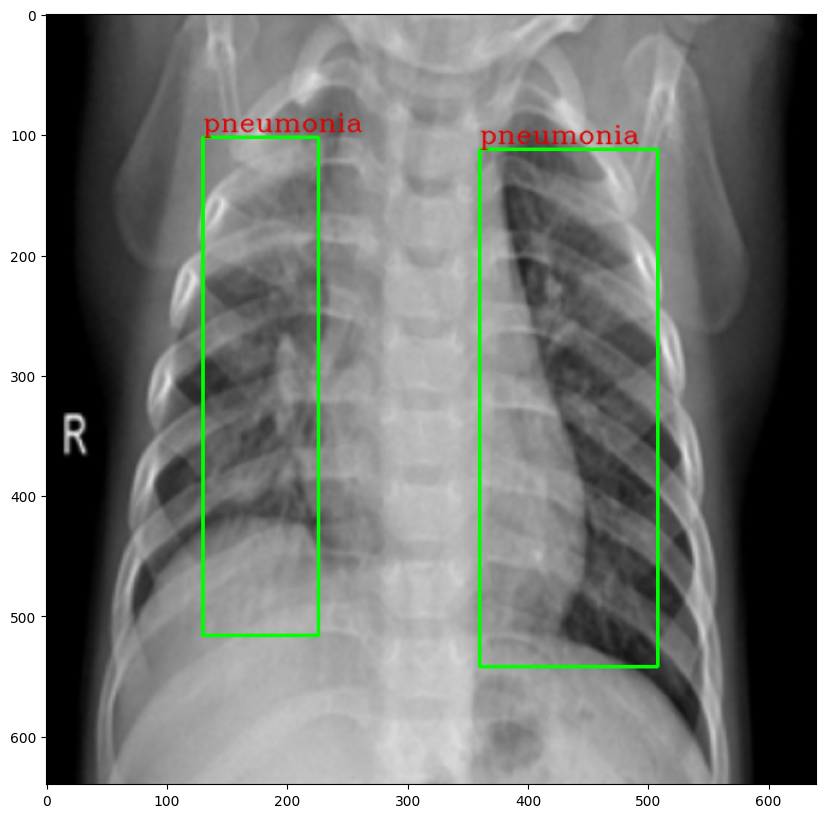

In [45]:
plot_img(val_dataset,124)

## Training a model, Saving model

In [46]:
torch.cuda.empty_cache()

In [47]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [48]:
# define the number of classes
num_classes = 3  # COVID, pneumonia, background

# load a pre-trained model
model = fasterrcnn(pretrained=True)

# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:04<00:00, 39.2MB/s]


In [49]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [50]:
params = [p for p in model.parameters() if p.requires_grad]

# optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
# optimizer = AdamW(params, lr=learning_rate, weight_decay=weight_decay)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# lr_scheduler = CosineAnnealingLR(optimizer,T_max = 100, eta_min = 10e-6, verbose = True)

# Define your optimizer
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Define your learning rate scheduler
lr_scheduler = OneCycleLR(optimizer, max_lr=1e-2, epochs=50, steps_per_epoch=len(train_data_loader))


In [51]:
import multiprocessing
print("Number of CPU cores:", multiprocessing.cpu_count())

Number of CPU cores: 2


In [52]:
print(tisum(
    model, 
    input_size = (batchsize,channels,dimension,dimension),
    depth =6
    ))

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [16, 3, 800, 800]         --
├─BackboneWithFPN: 1-2                                  [16, 256, 13, 13]         --
│    └─IntermediateLayerGetter: 2-1                     [16, 2048, 25, 25]        --
│    │    └─Conv2d: 3-1                                 [16, 64, 400, 400]        (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [16, 64, 400, 400]        --
│    │    └─ReLU: 3-3                                   [16, 64, 400, 400]        --
│    │    └─MaxPool2d: 3-4                              [16, 64, 200, 200]        --
│    │    └─Sequential: 3-5                             [16, 256, 200, 200]       --
│    │    │    └─Bottleneck: 4-1                        [16, 256, 200, 200]       --
│    │    │    │    └─Conv2d: 5-1                      

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


In [53]:
%%time
# let's train it for 2 epochs
num_epochs = 50

for epoch in trange(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    
    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

    # Write code to save model here
    torch.save(model.state_dict(), f'faster_rcnn_state_{epoch+1}_epoch.pt')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: [0]  [ 0/46]  eta: 0:15:05  lr: 0.000009  loss: 1.5210 (1.5210)  loss_classifier: 1.3678 (1.3678)  loss_box_reg: 0.1118 (0.1118)  loss_objectness: 0.0236 (0.0236)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 19.6819  data: 15.8988  max mem: 10771
Epoch: [0]  [10/46]  eta: 0:02:50  lr: 0.000098  loss: 0.8007 (0.8984)  loss_classifier: 0.3309 (0.5885)  loss_box_reg: 0.1295 (0.1473)  loss_objectness: 0.1250 (0.1348)  loss_rpn_box_reg: 0.0178 (0.0278)  time: 4.7291  data: 1.5183  max mem: 10771
Epoch: [0]  [20/46]  eta: 0:01:44  lr: 0.000187  loss: 0.4202 (0.6545)  loss_classifier: 0.1760 (0.3755)  loss_box_reg: 0.1468 (0.1495)  loss_objectness: 0.1059 (0.1033)  loss_rpn_box_reg: 0.0195 (0.0262)  time: 3.2406  data: 0.0746  max mem: 10771
Epoch: [0]  [30/46]  eta: 0:01:00  lr: 0.000276  loss: 0.3616 (0.5708)  loss_classifier: 0.1530 (0.3174)  loss_box_reg: 0.1380 (0.1439)  loss_objectness: 0.0538 (0.0868)  loss_rpn_box_reg: 0.0176 (0.0227)  time: 3.2710  data: 0.0675  max mem: 10771
Ep

  2%|▏         | 1/50 [03:07<2:32:50, 187.15s/it]

Epoch: [1]  [ 0/46]  eta: 0:03:47  lr: 0.000400  loss: 0.7148 (0.7148)  loss_classifier: 0.1609 (0.1609)  loss_box_reg: 0.0441 (0.0441)  loss_objectness: 0.4740 (0.4740)  loss_rpn_box_reg: 0.0358 (0.0358)  time: 4.9507  data: 1.4104  max mem: 10771
Epoch: [1]  [10/46]  eta: 0:02:04  lr: 0.000400  loss: 0.4435 (0.4975)  loss_classifier: 0.1865 (0.1921)  loss_box_reg: 0.1441 (0.1438)  loss_objectness: 0.0628 (0.1303)  loss_rpn_box_reg: 0.0130 (0.0313)  time: 3.4572  data: 0.1928  max mem: 10771
Epoch: [1]  [20/46]  eta: 0:01:28  lr: 0.000400  loss: 0.3842 (0.4356)  loss_classifier: 0.1464 (0.1632)  loss_box_reg: 0.1376 (0.1360)  loss_objectness: 0.0700 (0.1057)  loss_rpn_box_reg: 0.0217 (0.0306)  time: 3.3081  data: 0.0702  max mem: 10771
Epoch: [1]  [30/46]  eta: 0:00:53  lr: 0.000400  loss: 0.3635 (0.4053)  loss_classifier: 0.1355 (0.1640)  loss_box_reg: 0.1162 (0.1280)  loss_objectness: 0.0584 (0.0877)  loss_rpn_box_reg: 0.0175 (0.0257)  time: 3.3249  data: 0.0712  max mem: 10771
Epoc

  4%|▍         | 2/50 [06:03<2:24:38, 180.81s/it]

Epoch: [2]  [ 0/46]  eta: 0:03:11  lr: 0.000400  loss: 0.3618 (0.3618)  loss_classifier: 0.2073 (0.2073)  loss_box_reg: 0.0895 (0.0895)  loss_objectness: 0.0585 (0.0585)  loss_rpn_box_reg: 0.0066 (0.0066)  time: 4.1587  data: 0.8891  max mem: 10771
Epoch: [2]  [10/46]  eta: 0:02:02  lr: 0.000400  loss: 0.4168 (0.4530)  loss_classifier: 0.1905 (0.1900)  loss_box_reg: 0.1457 (0.1444)  loss_objectness: 0.0649 (0.0912)  loss_rpn_box_reg: 0.0133 (0.0275)  time: 3.4155  data: 0.1474  max mem: 10771
Epoch: [2]  [20/46]  eta: 0:01:28  lr: 0.000400  loss: 0.3597 (0.3990)  loss_classifier: 0.1278 (0.1552)  loss_box_reg: 0.1310 (0.1339)  loss_objectness: 0.0677 (0.0824)  loss_rpn_box_reg: 0.0208 (0.0275)  time: 3.3486  data: 0.0742  max mem: 10771
Epoch: [2]  [30/46]  eta: 0:00:53  lr: 0.000400  loss: 0.3316 (0.3764)  loss_classifier: 0.1240 (0.1541)  loss_box_reg: 0.1187 (0.1267)  loss_objectness: 0.0615 (0.0722)  loss_rpn_box_reg: 0.0175 (0.0235)  time: 3.3510  data: 0.0719  max mem: 10771
Epoc

  6%|▌         | 3/50 [08:59<2:20:02, 178.77s/it]

Epoch: [3]  [ 0/46]  eta: 0:03:51  lr: 0.000400  loss: 0.3092 (0.3092)  loss_classifier: 0.1737 (0.1737)  loss_box_reg: 0.0584 (0.0584)  loss_objectness: 0.0690 (0.0690)  loss_rpn_box_reg: 0.0082 (0.0082)  time: 5.0360  data: 1.5871  max mem: 10771
Epoch: [3]  [10/46]  eta: 0:02:05  lr: 0.000400  loss: 0.3949 (0.4630)  loss_classifier: 0.1859 (0.1905)  loss_box_reg: 0.1245 (0.1422)  loss_objectness: 0.0690 (0.1035)  loss_rpn_box_reg: 0.0145 (0.0268)  time: 3.4994  data: 0.2041  max mem: 10771
Epoch: [3]  [20/46]  eta: 0:01:29  lr: 0.000400  loss: 0.3740 (0.4041)  loss_classifier: 0.1529 (0.1592)  loss_box_reg: 0.1223 (0.1289)  loss_objectness: 0.0647 (0.0887)  loss_rpn_box_reg: 0.0196 (0.0273)  time: 3.3477  data: 0.0685  max mem: 10771
Epoch: [3]  [30/46]  eta: 0:00:54  lr: 0.000400  loss: 0.3124 (0.3661)  loss_classifier: 0.1210 (0.1478)  loss_box_reg: 0.1040 (0.1194)  loss_objectness: 0.0626 (0.0754)  loss_rpn_box_reg: 0.0187 (0.0236)  time: 3.3542  data: 0.0730  max mem: 10771
Epoc

  8%|▊         | 4/50 [11:56<2:16:30, 178.06s/it]

Epoch: [4]  [ 0/46]  eta: 0:03:09  lr: 0.000401  loss: 0.3274 (0.3274)  loss_classifier: 0.1753 (0.1753)  loss_box_reg: 0.0871 (0.0871)  loss_objectness: 0.0563 (0.0563)  loss_rpn_box_reg: 0.0087 (0.0087)  time: 4.1302  data: 0.8778  max mem: 10771
Epoch: [4]  [10/46]  eta: 0:02:02  lr: 0.000401  loss: 0.3370 (0.4224)  loss_classifier: 0.1645 (0.1718)  loss_box_reg: 0.1051 (0.1253)  loss_objectness: 0.0621 (0.0985)  loss_rpn_box_reg: 0.0137 (0.0267)  time: 3.4119  data: 0.1463  max mem: 10771
Epoch: [4]  [20/46]  eta: 0:01:27  lr: 0.000401  loss: 0.3383 (0.3853)  loss_classifier: 0.1322 (0.1523)  loss_box_reg: 0.1132 (0.1214)  loss_objectness: 0.0626 (0.0854)  loss_rpn_box_reg: 0.0196 (0.0261)  time: 3.3359  data: 0.0708  max mem: 10771
Epoch: [4]  [30/46]  eta: 0:00:53  lr: 0.000401  loss: 0.3308 (0.3675)  loss_classifier: 0.1344 (0.1552)  loss_box_reg: 0.1114 (0.1152)  loss_objectness: 0.0579 (0.0742)  loss_rpn_box_reg: 0.0196 (0.0229)  time: 3.3504  data: 0.0705  max mem: 10771
Epoc

 10%|█         | 5/50 [14:53<2:13:10, 177.58s/it]

Epoch: [5]  [ 0/46]  eta: 0:03:09  lr: 0.000401  loss: 0.2510 (0.2510)  loss_classifier: 0.1331 (0.1331)  loss_box_reg: 0.0667 (0.0667)  loss_objectness: 0.0434 (0.0434)  loss_rpn_box_reg: 0.0078 (0.0078)  time: 4.1241  data: 0.8909  max mem: 10771
Epoch: [5]  [10/46]  eta: 0:02:02  lr: 0.000401  loss: 0.3859 (0.4552)  loss_classifier: 0.1838 (0.1905)  loss_box_reg: 0.1299 (0.1421)  loss_objectness: 0.0600 (0.0967)  loss_rpn_box_reg: 0.0136 (0.0260)  time: 3.3921  data: 0.1426  max mem: 10771
Epoch: [5]  [20/46]  eta: 0:01:27  lr: 0.000401  loss: 0.3742 (0.4100)  loss_classifier: 0.1723 (0.1703)  loss_box_reg: 0.1247 (0.1321)  loss_objectness: 0.0582 (0.0810)  loss_rpn_box_reg: 0.0203 (0.0266)  time: 3.3418  data: 0.0717  max mem: 10771
Epoch: [5]  [30/46]  eta: 0:00:53  lr: 0.000401  loss: 0.3385 (0.3887)  loss_classifier: 0.1409 (0.1633)  loss_box_reg: 0.1125 (0.1323)  loss_objectness: 0.0512 (0.0702)  loss_rpn_box_reg: 0.0175 (0.0230)  time: 3.3562  data: 0.0752  max mem: 10771
Epoc

 12%|█▏        | 6/50 [17:49<2:09:47, 176.99s/it]

Epoch: [6]  [ 0/46]  eta: 0:03:17  lr: 0.000402  loss: 0.4252 (0.4252)  loss_classifier: 0.2435 (0.2435)  loss_box_reg: 0.0630 (0.0630)  loss_objectness: 0.1087 (0.1087)  loss_rpn_box_reg: 0.0101 (0.0101)  time: 4.2891  data: 0.9965  max mem: 10771
Epoch: [6]  [10/46]  eta: 0:02:03  lr: 0.000402  loss: 0.4252 (0.4386)  loss_classifier: 0.1938 (0.1917)  loss_box_reg: 0.1294 (0.1206)  loss_objectness: 0.0836 (0.1011)  loss_rpn_box_reg: 0.0131 (0.0253)  time: 3.4206  data: 0.1518  max mem: 10771
Epoch: [6]  [20/46]  eta: 0:01:27  lr: 0.000402  loss: 0.3165 (0.3813)  loss_classifier: 0.1261 (0.1571)  loss_box_reg: 0.1077 (0.1139)  loss_objectness: 0.0672 (0.0844)  loss_rpn_box_reg: 0.0184 (0.0258)  time: 3.3357  data: 0.0683  max mem: 10771
Epoch: [6]  [30/46]  eta: 0:00:54  lr: 0.000402  loss: 0.3075 (0.3535)  loss_classifier: 0.1247 (0.1526)  loss_box_reg: 0.1035 (0.1076)  loss_objectness: 0.0535 (0.0710)  loss_rpn_box_reg: 0.0184 (0.0223)  time: 3.3546  data: 0.0688  max mem: 10771
Epoc

 14%|█▍        | 7/50 [20:46<2:06:53, 177.06s/it]

Epoch: [7]  [ 0/46]  eta: 0:03:14  lr: 0.000402  loss: 0.2807 (0.2807)  loss_classifier: 0.1704 (0.1704)  loss_box_reg: 0.0661 (0.0661)  loss_objectness: 0.0373 (0.0373)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 4.2302  data: 0.9920  max mem: 10771
Epoch: [7]  [10/46]  eta: 0:02:03  lr: 0.000402  loss: 0.3801 (0.4489)  loss_classifier: 0.1918 (0.1947)  loss_box_reg: 0.1212 (0.1315)  loss_objectness: 0.0590 (0.0943)  loss_rpn_box_reg: 0.0155 (0.0283)  time: 3.4243  data: 0.1524  max mem: 10771
Epoch: [7]  [20/46]  eta: 0:01:28  lr: 0.000402  loss: 0.3752 (0.4096)  loss_classifier: 0.1690 (0.1706)  loss_box_reg: 0.1166 (0.1236)  loss_objectness: 0.0687 (0.0876)  loss_rpn_box_reg: 0.0202 (0.0278)  time: 3.3446  data: 0.0684  max mem: 10771
Epoch: [7]  [30/46]  eta: 0:00:53  lr: 0.000402  loss: 0.3752 (0.4102)  loss_classifier: 0.1624 (0.1746)  loss_box_reg: 0.1223 (0.1383)  loss_objectness: 0.0551 (0.0735)  loss_rpn_box_reg: 0.0184 (0.0239)  time: 3.3461  data: 0.0693  max mem: 10771
Epoc

 16%|█▌        | 8/50 [23:43<2:03:52, 176.97s/it]

Epoch: [8]  [ 0/46]  eta: 0:03:48  lr: 0.000403  loss: 0.4471 (0.4471)  loss_classifier: 0.2617 (0.2617)  loss_box_reg: 0.0911 (0.0911)  loss_objectness: 0.0817 (0.0817)  loss_rpn_box_reg: 0.0127 (0.0127)  time: 4.9611  data: 1.4341  max mem: 10771
Epoch: [8]  [10/46]  eta: 0:02:05  lr: 0.000403  loss: 0.3723 (0.4590)  loss_classifier: 0.1846 (0.2146)  loss_box_reg: 0.1013 (0.1180)  loss_objectness: 0.0748 (0.0969)  loss_rpn_box_reg: 0.0146 (0.0295)  time: 3.4755  data: 0.1950  max mem: 10771
Epoch: [8]  [20/46]  eta: 0:01:28  lr: 0.000403  loss: 0.3332 (0.3938)  loss_classifier: 0.1296 (0.1725)  loss_box_reg: 0.1064 (0.1128)  loss_objectness: 0.0608 (0.0800)  loss_rpn_box_reg: 0.0188 (0.0286)  time: 3.3327  data: 0.0727  max mem: 10771
Epoch: [8]  [30/46]  eta: 0:00:54  lr: 0.000403  loss: 0.3312 (0.3849)  loss_classifier: 0.1293 (0.1680)  loss_box_reg: 0.1076 (0.1219)  loss_objectness: 0.0552 (0.0704)  loss_rpn_box_reg: 0.0185 (0.0246)  time: 3.3445  data: 0.0720  max mem: 10771
Epoc

 18%|█▊        | 9/50 [26:39<2:00:50, 176.83s/it]

Epoch: [9]  [ 0/46]  eta: 0:03:13  lr: 0.000404  loss: 0.2988 (0.2988)  loss_classifier: 0.1540 (0.1540)  loss_box_reg: 0.0785 (0.0785)  loss_objectness: 0.0577 (0.0577)  loss_rpn_box_reg: 0.0087 (0.0087)  time: 4.2029  data: 0.9204  max mem: 10771
Epoch: [9]  [10/46]  eta: 0:02:03  lr: 0.000404  loss: 0.3500 (0.4082)  loss_classifier: 0.1548 (0.1674)  loss_box_reg: 0.1122 (0.1239)  loss_objectness: 0.0633 (0.0909)  loss_rpn_box_reg: 0.0129 (0.0259)  time: 3.4279  data: 0.1491  max mem: 10771
Epoch: [9]  [20/46]  eta: 0:01:28  lr: 0.000404  loss: 0.3184 (0.3653)  loss_classifier: 0.1188 (0.1412)  loss_box_reg: 0.1123 (0.1196)  loss_objectness: 0.0607 (0.0789)  loss_rpn_box_reg: 0.0183 (0.0256)  time: 3.3455  data: 0.0718  max mem: 10771
Epoch: [9]  [30/46]  eta: 0:00:54  lr: 0.000404  loss: 0.3062 (0.3528)  loss_classifier: 0.1143 (0.1432)  loss_box_reg: 0.1119 (0.1203)  loss_objectness: 0.0516 (0.0667)  loss_rpn_box_reg: 0.0183 (0.0226)  time: 3.3616  data: 0.0836  max mem: 10771
Epoc

 20%|██        | 10/50 [29:37<1:57:58, 176.97s/it]

Epoch: [10]  [ 0/46]  eta: 0:03:10  lr: 0.000405  loss: 0.3585 (0.3585)  loss_classifier: 0.2430 (0.2430)  loss_box_reg: 0.0658 (0.0658)  loss_objectness: 0.0400 (0.0400)  loss_rpn_box_reg: 0.0097 (0.0097)  time: 4.1400  data: 0.8938  max mem: 10771
Epoch: [10]  [10/46]  eta: 0:02:02  lr: 0.000405  loss: 0.4139 (0.4408)  loss_classifier: 0.1975 (0.1934)  loss_box_reg: 0.1144 (0.1250)  loss_objectness: 0.0724 (0.0957)  loss_rpn_box_reg: 0.0156 (0.0267)  time: 3.4000  data: 0.1439  max mem: 10771
Epoch: [10]  [20/46]  eta: 0:01:28  lr: 0.000405  loss: 0.3823 (0.4009)  loss_classifier: 0.1566 (0.1679)  loss_box_reg: 0.1167 (0.1220)  loss_objectness: 0.0721 (0.0845)  loss_rpn_box_reg: 0.0186 (0.0265)  time: 3.3503  data: 0.0784  max mem: 10771
Epoch: [10]  [30/46]  eta: 0:00:53  lr: 0.000405  loss: 0.3540 (0.3959)  loss_classifier: 0.1547 (0.1725)  loss_box_reg: 0.1170 (0.1298)  loss_objectness: 0.0539 (0.0708)  loss_rpn_box_reg: 0.0177 (0.0228)  time: 3.3564  data: 0.0790  max mem: 10771


 22%|██▏       | 11/50 [32:33<1:54:49, 176.66s/it]

Epoch: [11]  [ 0/46]  eta: 0:03:18  lr: 0.000406  loss: 0.2703 (0.2703)  loss_classifier: 0.1568 (0.1568)  loss_box_reg: 0.0618 (0.0618)  loss_objectness: 0.0430 (0.0430)  loss_rpn_box_reg: 0.0087 (0.0087)  time: 4.3185  data: 0.8365  max mem: 10771
Epoch: [11]  [10/46]  eta: 0:02:02  lr: 0.000406  loss: 0.3702 (0.4699)  loss_classifier: 0.1870 (0.2020)  loss_box_reg: 0.1028 (0.1209)  loss_objectness: 0.0782 (0.1187)  loss_rpn_box_reg: 0.0172 (0.0282)  time: 3.4134  data: 0.1371  max mem: 10771
Epoch: [11]  [20/46]  eta: 0:01:27  lr: 0.000406  loss: 0.3892 (0.4295)  loss_classifier: 0.1657 (0.1783)  loss_box_reg: 0.1183 (0.1189)  loss_objectness: 0.0894 (0.1056)  loss_rpn_box_reg: 0.0177 (0.0267)  time: 3.3286  data: 0.0684  max mem: 10771
Epoch: [11]  [30/46]  eta: 0:00:53  lr: 0.000406  loss: 0.3503 (0.4025)  loss_classifier: 0.1495 (0.1713)  loss_box_reg: 0.1213 (0.1234)  loss_objectness: 0.0527 (0.0843)  loss_rpn_box_reg: 0.0174 (0.0235)  time: 3.3371  data: 0.0696  max mem: 10771


 24%|██▍       | 12/50 [35:29<1:51:49, 176.55s/it]

Epoch: [12]  [ 0/46]  eta: 0:03:14  lr: 0.000407  loss: 0.3425 (0.3425)  loss_classifier: 0.1874 (0.1874)  loss_box_reg: 0.0735 (0.0735)  loss_objectness: 0.0727 (0.0727)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 4.2177  data: 0.9896  max mem: 10771
Epoch: [12]  [10/46]  eta: 0:02:01  lr: 0.000407  loss: 0.3797 (0.4539)  loss_classifier: 0.1874 (0.1903)  loss_box_reg: 0.1241 (0.1340)  loss_objectness: 0.0597 (0.1032)  loss_rpn_box_reg: 0.0139 (0.0264)  time: 3.3870  data: 0.1495  max mem: 10771
Epoch: [12]  [20/46]  eta: 0:01:28  lr: 0.000407  loss: 0.3449 (0.3951)  loss_classifier: 0.1359 (0.1571)  loss_box_reg: 0.1162 (0.1258)  loss_objectness: 0.0614 (0.0857)  loss_rpn_box_reg: 0.0190 (0.0265)  time: 3.3650  data: 0.0755  max mem: 10771
Epoch: [12]  [30/46]  eta: 0:00:54  lr: 0.000407  loss: 0.3449 (0.3927)  loss_classifier: 0.1264 (0.1636)  loss_box_reg: 0.1181 (0.1342)  loss_objectness: 0.0493 (0.0722)  loss_rpn_box_reg: 0.0174 (0.0228)  time: 3.3971  data: 0.0901  max mem: 10771


 26%|██▌       | 13/50 [38:25<1:48:47, 176.41s/it]

Epoch: [13]  [ 0/46]  eta: 0:03:35  lr: 0.000408  loss: 0.3678 (0.3678)  loss_classifier: 0.2218 (0.2218)  loss_box_reg: 0.0982 (0.0982)  loss_objectness: 0.0393 (0.0393)  loss_rpn_box_reg: 0.0084 (0.0084)  time: 4.6849  data: 1.1091  max mem: 10771
Epoch: [13]  [10/46]  eta: 0:02:03  lr: 0.000408  loss: 0.4068 (0.4654)  loss_classifier: 0.2072 (0.2104)  loss_box_reg: 0.1314 (0.1421)  loss_objectness: 0.0582 (0.0839)  loss_rpn_box_reg: 0.0155 (0.0289)  time: 3.4434  data: 0.1659  max mem: 10771
Epoch: [13]  [20/46]  eta: 0:01:28  lr: 0.000408  loss: 0.3676 (0.4062)  loss_classifier: 0.1472 (0.1729)  loss_box_reg: 0.1230 (0.1308)  loss_objectness: 0.0613 (0.0753)  loss_rpn_box_reg: 0.0192 (0.0272)  time: 3.3201  data: 0.0708  max mem: 10771
Epoch: [13]  [30/46]  eta: 0:00:54  lr: 0.000408  loss: 0.3524 (0.4023)  loss_classifier: 0.1353 (0.1801)  loss_box_reg: 0.1194 (0.1349)  loss_objectness: 0.0443 (0.0639)  loss_rpn_box_reg: 0.0177 (0.0235)  time: 3.3486  data: 0.0821  max mem: 10771


 28%|██▊       | 14/50 [41:22<1:45:54, 176.50s/it]

Epoch: [14]  [ 0/46]  eta: 0:03:15  lr: 0.000410  loss: 0.2498 (0.2498)  loss_classifier: 0.1500 (0.1500)  loss_box_reg: 0.0579 (0.0579)  loss_objectness: 0.0334 (0.0334)  loss_rpn_box_reg: 0.0084 (0.0084)  time: 4.2433  data: 0.9724  max mem: 10771
Epoch: [14]  [10/46]  eta: 0:02:01  lr: 0.000410  loss: 0.3774 (0.4412)  loss_classifier: 0.1881 (0.1950)  loss_box_reg: 0.1212 (0.1245)  loss_objectness: 0.0570 (0.0960)  loss_rpn_box_reg: 0.0164 (0.0257)  time: 3.3837  data: 0.1486  max mem: 10771
Epoch: [14]  [20/46]  eta: 0:01:27  lr: 0.000410  loss: 0.3282 (0.3864)  loss_classifier: 0.1232 (0.1575)  loss_box_reg: 0.1158 (0.1211)  loss_objectness: 0.0624 (0.0816)  loss_rpn_box_reg: 0.0207 (0.0262)  time: 3.3287  data: 0.0791  max mem: 10771
Epoch: [14]  [30/46]  eta: 0:00:53  lr: 0.000410  loss: 0.3098 (0.3736)  loss_classifier: 0.1226 (0.1568)  loss_box_reg: 0.1123 (0.1230)  loss_objectness: 0.0516 (0.0710)  loss_rpn_box_reg: 0.0205 (0.0228)  time: 3.3484  data: 0.0810  max mem: 10771


 30%|███       | 15/50 [44:17<1:42:47, 176.20s/it]

Epoch: [15]  [ 0/46]  eta: 0:03:48  lr: 0.000411  loss: 0.2544 (0.2544)  loss_classifier: 0.1501 (0.1501)  loss_box_reg: 0.0530 (0.0530)  loss_objectness: 0.0410 (0.0410)  loss_rpn_box_reg: 0.0104 (0.0104)  time: 4.9671  data: 1.3281  max mem: 10771
Epoch: [15]  [10/46]  eta: 0:02:04  lr: 0.000411  loss: 0.3604 (0.4085)  loss_classifier: 0.1701 (0.1779)  loss_box_reg: 0.1117 (0.1192)  loss_objectness: 0.0565 (0.0838)  loss_rpn_box_reg: 0.0157 (0.0275)  time: 3.4679  data: 0.2001  max mem: 10771
Epoch: [15]  [20/46]  eta: 0:01:28  lr: 0.000411  loss: 0.3458 (0.3786)  loss_classifier: 0.1472 (0.1574)  loss_box_reg: 0.1099 (0.1121)  loss_objectness: 0.0717 (0.0816)  loss_rpn_box_reg: 0.0213 (0.0274)  time: 3.3221  data: 0.0813  max mem: 10771
Epoch: [15]  [30/46]  eta: 0:00:54  lr: 0.000411  loss: 0.3220 (0.3566)  loss_classifier: 0.1240 (0.1480)  loss_box_reg: 0.1018 (0.1154)  loss_objectness: 0.0551 (0.0701)  loss_rpn_box_reg: 0.0182 (0.0232)  time: 3.3299  data: 0.0736  max mem: 10771


 32%|███▏      | 16/50 [47:13<1:39:49, 176.15s/it]

Epoch: [16]  [ 0/46]  eta: 0:03:17  lr: 0.000413  loss: 0.4098 (0.4098)  loss_classifier: 0.2794 (0.2794)  loss_box_reg: 0.0834 (0.0834)  loss_objectness: 0.0391 (0.0391)  loss_rpn_box_reg: 0.0079 (0.0079)  time: 4.2848  data: 0.9907  max mem: 10771
Epoch: [16]  [10/46]  eta: 0:02:03  lr: 0.000413  loss: 0.4094 (0.4429)  loss_classifier: 0.2193 (0.2083)  loss_box_reg: 0.1127 (0.1201)  loss_objectness: 0.0637 (0.0869)  loss_rpn_box_reg: 0.0147 (0.0275)  time: 3.4288  data: 0.1720  max mem: 10771
Epoch: [16]  [20/46]  eta: 0:01:27  lr: 0.000413  loss: 0.3295 (0.3860)  loss_classifier: 0.1417 (0.1719)  loss_box_reg: 0.1025 (0.1088)  loss_objectness: 0.0661 (0.0780)  loss_rpn_box_reg: 0.0211 (0.0273)  time: 3.3308  data: 0.0776  max mem: 10771
Epoch: [16]  [30/46]  eta: 0:00:53  lr: 0.000413  loss: 0.3278 (0.3648)  loss_classifier: 0.1292 (0.1586)  loss_box_reg: 0.1025 (0.1142)  loss_objectness: 0.0534 (0.0687)  loss_rpn_box_reg: 0.0182 (0.0233)  time: 3.3279  data: 0.0666  max mem: 10771


 34%|███▍      | 17/50 [50:09<1:36:50, 176.07s/it]

Epoch: [17]  [ 0/46]  eta: 0:03:30  lr: 0.000414  loss: 0.2246 (0.2246)  loss_classifier: 0.1349 (0.1349)  loss_box_reg: 0.0469 (0.0469)  loss_objectness: 0.0353 (0.0353)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 4.5825  data: 1.3249  max mem: 10771
Epoch: [17]  [10/46]  eta: 0:02:04  lr: 0.000414  loss: 0.3266 (0.4167)  loss_classifier: 0.1663 (0.1842)  loss_box_reg: 0.1032 (0.1209)  loss_objectness: 0.0489 (0.0834)  loss_rpn_box_reg: 0.0152 (0.0283)  time: 3.4558  data: 0.1926  max mem: 10771
Epoch: [17]  [20/46]  eta: 0:01:28  lr: 0.000414  loss: 0.3724 (0.3952)  loss_classifier: 0.1446 (0.1642)  loss_box_reg: 0.1227 (0.1250)  loss_objectness: 0.0631 (0.0777)  loss_rpn_box_reg: 0.0210 (0.0283)  time: 3.3302  data: 0.0738  max mem: 10771
Epoch: [17]  [30/46]  eta: 0:00:53  lr: 0.000414  loss: 0.3484 (0.3795)  loss_classifier: 0.1425 (0.1594)  loss_box_reg: 0.1186 (0.1281)  loss_objectness: 0.0486 (0.0676)  loss_rpn_box_reg: 0.0210 (0.0244)  time: 3.3240  data: 0.0694  max mem: 10771


 36%|███▌      | 18/50 [53:05<1:33:48, 175.90s/it]

Epoch: [18]  [ 0/46]  eta: 0:03:12  lr: 0.000416  loss: 0.3867 (0.3867)  loss_classifier: 0.1904 (0.1904)  loss_box_reg: 0.0772 (0.0772)  loss_objectness: 0.1069 (0.1069)  loss_rpn_box_reg: 0.0122 (0.0122)  time: 4.1749  data: 0.9311  max mem: 10771
Epoch: [18]  [10/46]  eta: 0:02:02  lr: 0.000416  loss: 0.3551 (0.4306)  loss_classifier: 0.1660 (0.1834)  loss_box_reg: 0.1064 (0.1256)  loss_objectness: 0.0615 (0.0918)  loss_rpn_box_reg: 0.0170 (0.0298)  time: 3.4078  data: 0.1442  max mem: 10771
Epoch: [18]  [20/46]  eta: 0:01:27  lr: 0.000416  loss: 0.3269 (0.3845)  loss_classifier: 0.1425 (0.1568)  loss_box_reg: 0.1100 (0.1215)  loss_objectness: 0.0564 (0.0768)  loss_rpn_box_reg: 0.0227 (0.0294)  time: 3.3393  data: 0.0747  max mem: 10771
Epoch: [18]  [30/46]  eta: 0:00:53  lr: 0.000416  loss: 0.3358 (0.3906)  loss_classifier: 0.1415 (0.1641)  loss_box_reg: 0.1213 (0.1351)  loss_objectness: 0.0493 (0.0665)  loss_rpn_box_reg: 0.0221 (0.0248)  time: 3.3362  data: 0.0775  max mem: 10771


 38%|███▊      | 19/50 [56:01<1:30:52, 175.89s/it]

Epoch: [19]  [ 0/46]  eta: 0:03:23  lr: 0.000418  loss: 0.3461 (0.3461)  loss_classifier: 0.2139 (0.2139)  loss_box_reg: 0.0824 (0.0824)  loss_objectness: 0.0406 (0.0406)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 4.4176  data: 1.1107  max mem: 10771
Epoch: [19]  [10/46]  eta: 0:02:02  lr: 0.000418  loss: 0.4264 (0.4490)  loss_classifier: 0.2139 (0.2042)  loss_box_reg: 0.1345 (0.1358)  loss_objectness: 0.0622 (0.0830)  loss_rpn_box_reg: 0.0157 (0.0260)  time: 3.4138  data: 0.1631  max mem: 10771
Epoch: [19]  [20/46]  eta: 0:01:27  lr: 0.000418  loss: 0.3295 (0.3805)  loss_classifier: 0.1231 (0.1557)  loss_box_reg: 0.1152 (0.1239)  loss_objectness: 0.0622 (0.0741)  loss_rpn_box_reg: 0.0218 (0.0267)  time: 3.3320  data: 0.0708  max mem: 10771
Epoch: [19]  [30/46]  eta: 0:00:53  lr: 0.000418  loss: 0.3216 (0.3954)  loss_classifier: 0.1088 (0.1683)  loss_box_reg: 0.1152 (0.1401)  loss_objectness: 0.0508 (0.0643)  loss_rpn_box_reg: 0.0200 (0.0228)  time: 3.3368  data: 0.0710  max mem: 10771


 40%|████      | 20/50 [58:56<1:27:53, 175.77s/it]

Epoch: [20]  [ 0/46]  eta: 0:03:10  lr: 0.000420  loss: 0.2888 (0.2888)  loss_classifier: 0.1773 (0.1773)  loss_box_reg: 0.0644 (0.0644)  loss_objectness: 0.0401 (0.0401)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 4.1513  data: 0.9366  max mem: 10771
Epoch: [20]  [10/46]  eta: 0:02:01  lr: 0.000420  loss: 0.3437 (0.4056)  loss_classifier: 0.1773 (0.1848)  loss_box_reg: 0.1028 (0.1181)  loss_objectness: 0.0553 (0.0780)  loss_rpn_box_reg: 0.0159 (0.0247)  time: 3.3846  data: 0.1455  max mem: 10771
Epoch: [20]  [20/46]  eta: 0:01:27  lr: 0.000420  loss: 0.3437 (0.3757)  loss_classifier: 0.1455 (0.1627)  loss_box_reg: 0.1081 (0.1144)  loss_objectness: 0.0609 (0.0731)  loss_rpn_box_reg: 0.0188 (0.0255)  time: 3.3110  data: 0.0686  max mem: 10771
Epoch: [20]  [30/46]  eta: 0:00:53  lr: 0.000420  loss: 0.3522 (0.3746)  loss_classifier: 0.1450 (0.1615)  loss_box_reg: 0.1155 (0.1273)  loss_objectness: 0.0484 (0.0635)  loss_rpn_box_reg: 0.0180 (0.0222)  time: 3.3315  data: 0.0689  max mem: 10771


 42%|████▏     | 21/50 [1:01:52<1:24:58, 175.83s/it]

Epoch: [21]  [ 0/46]  eta: 0:03:11  lr: 0.000422  loss: 0.2731 (0.2731)  loss_classifier: 0.1627 (0.1627)  loss_box_reg: 0.0670 (0.0670)  loss_objectness: 0.0350 (0.0350)  loss_rpn_box_reg: 0.0084 (0.0084)  time: 4.1637  data: 0.8988  max mem: 10771
Epoch: [21]  [10/46]  eta: 0:02:01  lr: 0.000422  loss: 0.3935 (0.4636)  loss_classifier: 0.1977 (0.2116)  loss_box_reg: 0.1216 (0.1364)  loss_objectness: 0.0612 (0.0901)  loss_rpn_box_reg: 0.0131 (0.0255)  time: 3.3886  data: 0.1415  max mem: 10771
Epoch: [21]  [20/46]  eta: 0:01:27  lr: 0.000422  loss: 0.3586 (0.4004)  loss_classifier: 0.1455 (0.1734)  loss_box_reg: 0.1216 (0.1267)  loss_objectness: 0.0548 (0.0742)  loss_rpn_box_reg: 0.0191 (0.0261)  time: 3.3259  data: 0.0696  max mem: 10771
Epoch: [21]  [30/46]  eta: 0:00:53  lr: 0.000422  loss: 0.3219 (0.3889)  loss_classifier: 0.1368 (0.1707)  loss_box_reg: 0.1180 (0.1307)  loss_objectness: 0.0477 (0.0651)  loss_rpn_box_reg: 0.0184 (0.0224)  time: 3.3409  data: 0.0712  max mem: 10771


 44%|████▍     | 22/50 [1:04:47<1:21:56, 175.58s/it]

Epoch: [22]  [ 0/46]  eta: 0:03:11  lr: 0.000424  loss: 0.3110 (0.3110)  loss_classifier: 0.2053 (0.2053)  loss_box_reg: 0.0577 (0.0577)  loss_objectness: 0.0403 (0.0403)  loss_rpn_box_reg: 0.0078 (0.0078)  time: 4.1536  data: 0.8992  max mem: 10771
Epoch: [22]  [10/46]  eta: 0:02:02  lr: 0.000424  loss: 0.3998 (0.4451)  loss_classifier: 0.2067 (0.2085)  loss_box_reg: 0.1193 (0.1227)  loss_objectness: 0.0585 (0.0843)  loss_rpn_box_reg: 0.0144 (0.0296)  time: 3.3986  data: 0.1449  max mem: 10771
Epoch: [22]  [20/46]  eta: 0:01:27  lr: 0.000424  loss: 0.3719 (0.3996)  loss_classifier: 0.1536 (0.1752)  loss_box_reg: 0.1104 (0.1164)  loss_objectness: 0.0660 (0.0797)  loss_rpn_box_reg: 0.0189 (0.0282)  time: 3.3273  data: 0.0705  max mem: 10771
Epoch: [22]  [30/46]  eta: 0:00:53  lr: 0.000424  loss: 0.3627 (0.3957)  loss_classifier: 0.1522 (0.1721)  loss_box_reg: 0.1108 (0.1331)  loss_objectness: 0.0536 (0.0666)  loss_rpn_box_reg: 0.0182 (0.0239)  time: 3.3301  data: 0.0710  max mem: 10771


 46%|████▌     | 23/50 [1:07:43<1:19:04, 175.71s/it]

Epoch: [23]  [ 0/46]  eta: 0:03:11  lr: 0.000426  loss: 0.4156 (0.4156)  loss_classifier: 0.2169 (0.2169)  loss_box_reg: 0.1185 (0.1185)  loss_objectness: 0.0700 (0.0700)  loss_rpn_box_reg: 0.0101 (0.0101)  time: 4.1667  data: 0.9317  max mem: 10771
Epoch: [23]  [10/46]  eta: 0:02:01  lr: 0.000426  loss: 0.4008 (0.4202)  loss_classifier: 0.1925 (0.1863)  loss_box_reg: 0.1187 (0.1319)  loss_objectness: 0.0591 (0.0764)  loss_rpn_box_reg: 0.0151 (0.0256)  time: 3.3674  data: 0.1428  max mem: 10771
Epoch: [23]  [20/46]  eta: 0:01:27  lr: 0.000426  loss: 0.3310 (0.3692)  loss_classifier: 0.1205 (0.1506)  loss_box_reg: 0.1143 (0.1233)  loss_objectness: 0.0578 (0.0692)  loss_rpn_box_reg: 0.0192 (0.0261)  time: 3.3093  data: 0.0674  max mem: 10771
Epoch: [23]  [30/46]  eta: 0:00:53  lr: 0.000426  loss: 0.3419 (0.3813)  loss_classifier: 0.1205 (0.1620)  loss_box_reg: 0.1143 (0.1368)  loss_objectness: 0.0465 (0.0601)  loss_rpn_box_reg: 0.0169 (0.0224)  time: 3.3347  data: 0.0697  max mem: 10771


 48%|████▊     | 24/50 [1:10:38<1:16:02, 175.47s/it]

Epoch: [24]  [ 0/46]  eta: 0:03:12  lr: 0.000429  loss: 0.2495 (0.2495)  loss_classifier: 0.1564 (0.1564)  loss_box_reg: 0.0541 (0.0541)  loss_objectness: 0.0310 (0.0310)  loss_rpn_box_reg: 0.0080 (0.0080)  time: 4.1838  data: 0.9042  max mem: 10771
Epoch: [24]  [10/46]  eta: 0:02:02  lr: 0.000429  loss: 0.3654 (0.4273)  loss_classifier: 0.1717 (0.1929)  loss_box_reg: 0.1183 (0.1272)  loss_objectness: 0.0478 (0.0821)  loss_rpn_box_reg: 0.0146 (0.0251)  time: 3.4048  data: 0.1539  max mem: 10771
Epoch: [24]  [20/46]  eta: 0:01:27  lr: 0.000429  loss: 0.3446 (0.3864)  loss_classifier: 0.1383 (0.1626)  loss_box_reg: 0.1234 (0.1248)  loss_objectness: 0.0561 (0.0730)  loss_rpn_box_reg: 0.0190 (0.0260)  time: 3.3291  data: 0.0769  max mem: 10771
Epoch: [24]  [30/46]  eta: 0:00:53  lr: 0.000429  loss: 0.3305 (0.3760)  loss_classifier: 0.1278 (0.1575)  loss_box_reg: 0.1248 (0.1323)  loss_objectness: 0.0515 (0.0637)  loss_rpn_box_reg: 0.0181 (0.0225)  time: 3.3377  data: 0.0748  max mem: 10771


 50%|█████     | 25/50 [1:13:34<1:13:13, 175.73s/it]

Epoch: [25]  [ 0/46]  eta: 0:03:09  lr: 0.000431  loss: 0.2705 (0.2705)  loss_classifier: 0.1432 (0.1432)  loss_box_reg: 0.0605 (0.0605)  loss_objectness: 0.0578 (0.0578)  loss_rpn_box_reg: 0.0090 (0.0090)  time: 4.1134  data: 0.8899  max mem: 10771
Epoch: [25]  [10/46]  eta: 0:02:01  lr: 0.000431  loss: 0.3388 (0.3908)  loss_classifier: 0.1684 (0.1665)  loss_box_reg: 0.1080 (0.1185)  loss_objectness: 0.0578 (0.0798)  loss_rpn_box_reg: 0.0138 (0.0260)  time: 3.3634  data: 0.1408  max mem: 10771
Epoch: [25]  [20/46]  eta: 0:01:26  lr: 0.000431  loss: 0.3260 (0.3540)  loss_classifier: 0.1277 (0.1442)  loss_box_reg: 0.1105 (0.1119)  loss_objectness: 0.0596 (0.0717)  loss_rpn_box_reg: 0.0188 (0.0262)  time: 3.3058  data: 0.0704  max mem: 10771
Epoch: [25]  [30/46]  eta: 0:00:53  lr: 0.000431  loss: 0.3254 (0.3654)  loss_classifier: 0.1277 (0.1538)  loss_box_reg: 0.1126 (0.1277)  loss_objectness: 0.0441 (0.0613)  loss_rpn_box_reg: 0.0187 (0.0225)  time: 3.3195  data: 0.0727  max mem: 10771


 52%|█████▏    | 26/50 [1:16:28<1:10:06, 175.26s/it]

Epoch: [26]  [ 0/46]  eta: 0:03:11  lr: 0.000434  loss: 0.2988 (0.2988)  loss_classifier: 0.1693 (0.1693)  loss_box_reg: 0.0592 (0.0592)  loss_objectness: 0.0627 (0.0627)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 4.1546  data: 0.9082  max mem: 10771
Epoch: [26]  [10/46]  eta: 0:02:02  lr: 0.000434  loss: 0.3500 (0.4096)  loss_classifier: 0.1813 (0.1820)  loss_box_reg: 0.1031 (0.1106)  loss_objectness: 0.0542 (0.0903)  loss_rpn_box_reg: 0.0161 (0.0267)  time: 3.3982  data: 0.1484  max mem: 10771
Epoch: [26]  [20/46]  eta: 0:01:27  lr: 0.000434  loss: 0.3348 (0.3695)  loss_classifier: 0.1434 (0.1552)  loss_box_reg: 0.1031 (0.1098)  loss_objectness: 0.0548 (0.0779)  loss_rpn_box_reg: 0.0190 (0.0266)  time: 3.3230  data: 0.0700  max mem: 10771
Epoch: [26]  [30/46]  eta: 0:00:53  lr: 0.000434  loss: 0.3579 (0.3809)  loss_classifier: 0.1304 (0.1638)  loss_box_reg: 0.1263 (0.1277)  loss_objectness: 0.0511 (0.0668)  loss_rpn_box_reg: 0.0178 (0.0226)  time: 3.3340  data: 0.0689  max mem: 10771


 54%|█████▍    | 27/50 [1:19:25<1:07:18, 175.60s/it]

Epoch: [27]  [ 0/46]  eta: 0:03:12  lr: 0.000436  loss: 0.3646 (0.3646)  loss_classifier: 0.2077 (0.2077)  loss_box_reg: 0.0911 (0.0911)  loss_objectness: 0.0572 (0.0572)  loss_rpn_box_reg: 0.0086 (0.0086)  time: 4.1914  data: 0.9105  max mem: 10771
Epoch: [27]  [10/46]  eta: 0:02:02  lr: 0.000436  loss: 0.3935 (0.4490)  loss_classifier: 0.1972 (0.1970)  loss_box_reg: 0.1361 (0.1450)  loss_objectness: 0.0572 (0.0820)  loss_rpn_box_reg: 0.0138 (0.0251)  time: 3.3919  data: 0.1459  max mem: 10771
Epoch: [27]  [20/46]  eta: 0:01:27  lr: 0.000436  loss: 0.3491 (0.3821)  loss_classifier: 0.1328 (0.1582)  loss_box_reg: 0.1142 (0.1265)  loss_objectness: 0.0576 (0.0711)  loss_rpn_box_reg: 0.0187 (0.0263)  time: 3.3178  data: 0.0697  max mem: 10771
Epoch: [27]  [30/46]  eta: 0:00:53  lr: 0.000436  loss: 0.3217 (0.3663)  loss_classifier: 0.1231 (0.1494)  loss_box_reg: 0.1135 (0.1276)  loss_objectness: 0.0569 (0.0664)  loss_rpn_box_reg: 0.0187 (0.0230)  time: 3.3207  data: 0.0710  max mem: 10771


 56%|█████▌    | 28/50 [1:22:19<1:04:14, 175.19s/it]

Epoch: [28]  [ 0/46]  eta: 0:03:18  lr: 0.000439  loss: 0.2527 (0.2527)  loss_classifier: 0.1426 (0.1426)  loss_box_reg: 0.0589 (0.0589)  loss_objectness: 0.0430 (0.0430)  loss_rpn_box_reg: 0.0082 (0.0082)  time: 4.3056  data: 1.0187  max mem: 10771
Epoch: [28]  [10/46]  eta: 0:02:01  lr: 0.000439  loss: 0.3667 (0.4153)  loss_classifier: 0.1812 (0.1858)  loss_box_reg: 0.1191 (0.1216)  loss_objectness: 0.0521 (0.0832)  loss_rpn_box_reg: 0.0155 (0.0246)  time: 3.3870  data: 0.1545  max mem: 10771
Epoch: [28]  [20/46]  eta: 0:01:27  lr: 0.000439  loss: 0.3472 (0.3780)  loss_classifier: 0.1464 (0.1616)  loss_box_reg: 0.1130 (0.1163)  loss_objectness: 0.0582 (0.0747)  loss_rpn_box_reg: 0.0190 (0.0254)  time: 3.3038  data: 0.0682  max mem: 10771
Epoch: [28]  [30/46]  eta: 0:00:53  lr: 0.000439  loss: 0.3472 (0.3957)  loss_classifier: 0.1464 (0.1744)  loss_box_reg: 0.1130 (0.1355)  loss_objectness: 0.0477 (0.0640)  loss_rpn_box_reg: 0.0178 (0.0218)  time: 3.3226  data: 0.0704  max mem: 10771


 58%|█████▊    | 29/50 [1:25:14<1:01:20, 175.26s/it]

Epoch: [29]  [ 0/46]  eta: 0:03:08  lr: 0.000442  loss: 0.2601 (0.2601)  loss_classifier: 0.1512 (0.1512)  loss_box_reg: 0.0659 (0.0659)  loss_objectness: 0.0352 (0.0352)  loss_rpn_box_reg: 0.0079 (0.0079)  time: 4.0892  data: 0.8448  max mem: 10771
Epoch: [29]  [10/46]  eta: 0:02:01  lr: 0.000442  loss: 0.3374 (0.4188)  loss_classifier: 0.1592 (0.1821)  loss_box_reg: 0.1220 (0.1338)  loss_objectness: 0.0524 (0.0763)  loss_rpn_box_reg: 0.0167 (0.0267)  time: 3.3720  data: 0.1383  max mem: 10771
Epoch: [29]  [20/46]  eta: 0:01:27  lr: 0.000442  loss: 0.3341 (0.3856)  loss_classifier: 0.1472 (0.1621)  loss_box_reg: 0.1220 (0.1273)  loss_objectness: 0.0527 (0.0698)  loss_rpn_box_reg: 0.0183 (0.0264)  time: 3.3096  data: 0.0721  max mem: 10771
Epoch: [29]  [30/46]  eta: 0:00:53  lr: 0.000442  loss: 0.3506 (0.3775)  loss_classifier: 0.1472 (0.1595)  loss_box_reg: 0.1257 (0.1340)  loss_objectness: 0.0505 (0.0606)  loss_rpn_box_reg: 0.0183 (0.0233)  time: 3.3125  data: 0.0744  max mem: 10771


 60%|██████    | 30/50 [1:28:08<58:16, 174.84s/it]  

Epoch: [30]  [ 0/46]  eta: 0:03:11  lr: 0.000445  loss: 0.2106 (0.2106)  loss_classifier: 0.1087 (0.1087)  loss_box_reg: 0.0542 (0.0542)  loss_objectness: 0.0391 (0.0391)  loss_rpn_box_reg: 0.0085 (0.0085)  time: 4.1606  data: 0.9453  max mem: 10771
Epoch: [30]  [10/46]  eta: 0:02:01  lr: 0.000445  loss: 0.2997 (0.3854)  loss_classifier: 0.1524 (0.1618)  loss_box_reg: 0.0968 (0.1149)  loss_objectness: 0.0549 (0.0821)  loss_rpn_box_reg: 0.0162 (0.0265)  time: 3.3766  data: 0.1512  max mem: 10771
Epoch: [30]  [20/46]  eta: 0:01:27  lr: 0.000445  loss: 0.3382 (0.3675)  loss_classifier: 0.1332 (0.1488)  loss_box_reg: 0.1240 (0.1192)  loss_objectness: 0.0572 (0.0736)  loss_rpn_box_reg: 0.0182 (0.0260)  time: 3.3124  data: 0.0722  max mem: 10771
Epoch: [30]  [30/46]  eta: 0:00:53  lr: 0.000445  loss: 0.3500 (0.3775)  loss_classifier: 0.1332 (0.1544)  loss_box_reg: 0.1285 (0.1378)  loss_objectness: 0.0454 (0.0628)  loss_rpn_box_reg: 0.0180 (0.0225)  time: 3.3276  data: 0.0715  max mem: 10771


 62%|██████▏   | 31/50 [1:31:04<55:26, 175.05s/it]

Epoch: [31]  [ 0/46]  eta: 0:03:12  lr: 0.000448  loss: 0.2900 (0.2900)  loss_classifier: 0.1838 (0.1838)  loss_box_reg: 0.0671 (0.0671)  loss_objectness: 0.0305 (0.0305)  loss_rpn_box_reg: 0.0086 (0.0086)  time: 4.1951  data: 0.9697  max mem: 10771
Epoch: [31]  [10/46]  eta: 0:02:02  lr: 0.000448  loss: 0.3481 (0.4144)  loss_classifier: 0.1838 (0.1753)  loss_box_reg: 0.1270 (0.1328)  loss_objectness: 0.0545 (0.0807)  loss_rpn_box_reg: 0.0150 (0.0256)  time: 3.3901  data: 0.1437  max mem: 10771
Epoch: [31]  [20/46]  eta: 0:01:27  lr: 0.000448  loss: 0.3301 (0.3697)  loss_classifier: 0.1294 (0.1464)  loss_box_reg: 0.1148 (0.1234)  loss_objectness: 0.0604 (0.0738)  loss_rpn_box_reg: 0.0191 (0.0262)  time: 3.3265  data: 0.0685  max mem: 10771
Epoch: [31]  [30/46]  eta: 0:00:53  lr: 0.000448  loss: 0.3252 (0.3632)  loss_classifier: 0.1152 (0.1490)  loss_box_reg: 0.1131 (0.1251)  loss_objectness: 0.0547 (0.0661)  loss_rpn_box_reg: 0.0191 (0.0229)  time: 3.3228  data: 0.0748  max mem: 10771


 64%|██████▍   | 32/50 [1:33:58<52:27, 174.88s/it]

Epoch: [32]  [ 0/46]  eta: 0:03:10  lr: 0.000451  loss: 0.2725 (0.2725)  loss_classifier: 0.1605 (0.1605)  loss_box_reg: 0.0544 (0.0544)  loss_objectness: 0.0487 (0.0487)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 4.1404  data: 0.8928  max mem: 10771
Epoch: [32]  [10/46]  eta: 0:02:02  lr: 0.000451  loss: 0.3055 (0.3897)  loss_classifier: 0.1419 (0.1551)  loss_box_reg: 0.1139 (0.1152)  loss_objectness: 0.0533 (0.0930)  loss_rpn_box_reg: 0.0147 (0.0264)  time: 3.3902  data: 0.1486  max mem: 10771
Epoch: [32]  [20/46]  eta: 0:01:27  lr: 0.000451  loss: 0.3055 (0.3526)  loss_classifier: 0.1170 (0.1328)  loss_box_reg: 0.1169 (0.1164)  loss_objectness: 0.0538 (0.0775)  loss_rpn_box_reg: 0.0189 (0.0259)  time: 3.3203  data: 0.0732  max mem: 10771
Epoch: [32]  [30/46]  eta: 0:00:53  lr: 0.000451  loss: 0.3051 (0.3502)  loss_classifier: 0.1154 (0.1399)  loss_box_reg: 0.1169 (0.1229)  loss_objectness: 0.0447 (0.0650)  loss_rpn_box_reg: 0.0188 (0.0224)  time: 3.3291  data: 0.0722  max mem: 10771


 66%|██████▌   | 33/50 [1:36:54<49:36, 175.11s/it]

Epoch: [33]  [ 0/46]  eta: 0:03:10  lr: 0.000454  loss: 0.2529 (0.2529)  loss_classifier: 0.1447 (0.1447)  loss_box_reg: 0.0640 (0.0640)  loss_objectness: 0.0354 (0.0354)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 4.1357  data: 0.8701  max mem: 10771
Epoch: [33]  [10/46]  eta: 0:02:01  lr: 0.000454  loss: 0.3334 (0.4039)  loss_classifier: 0.1602 (0.1775)  loss_box_reg: 0.1041 (0.1149)  loss_objectness: 0.0513 (0.0837)  loss_rpn_box_reg: 0.0151 (0.0278)  time: 3.3725  data: 0.1407  max mem: 10771
Epoch: [33]  [20/46]  eta: 0:01:27  lr: 0.000454  loss: 0.3323 (0.3620)  loss_classifier: 0.1331 (0.1497)  loss_box_reg: 0.1080 (0.1138)  loss_objectness: 0.0534 (0.0717)  loss_rpn_box_reg: 0.0175 (0.0268)  time: 3.3170  data: 0.0709  max mem: 10771
Epoch: [33]  [30/46]  eta: 0:00:53  lr: 0.000454  loss: 0.3294 (0.3610)  loss_classifier: 0.1282 (0.1527)  loss_box_reg: 0.1185 (0.1235)  loss_objectness: 0.0458 (0.0619)  loss_rpn_box_reg: 0.0175 (0.0229)  time: 3.3300  data: 0.0732  max mem: 10771


 68%|██████▊   | 34/50 [1:39:48<46:37, 174.84s/it]

Epoch: [34]  [ 0/46]  eta: 0:03:18  lr: 0.000458  loss: 0.2159 (0.2159)  loss_classifier: 0.1339 (0.1339)  loss_box_reg: 0.0459 (0.0459)  loss_objectness: 0.0276 (0.0276)  loss_rpn_box_reg: 0.0085 (0.0085)  time: 4.3047  data: 1.0684  max mem: 10771
Epoch: [34]  [10/46]  eta: 0:02:02  lr: 0.000458  loss: 0.3613 (0.4056)  loss_classifier: 0.2002 (0.1867)  loss_box_reg: 0.1089 (0.1122)  loss_objectness: 0.0432 (0.0797)  loss_rpn_box_reg: 0.0170 (0.0270)  time: 3.4136  data: 0.1597  max mem: 10771
Epoch: [34]  [20/46]  eta: 0:01:27  lr: 0.000458  loss: 0.3500 (0.3704)  loss_classifier: 0.1460 (0.1572)  loss_box_reg: 0.1161 (0.1162)  loss_objectness: 0.0493 (0.0706)  loss_rpn_box_reg: 0.0182 (0.0264)  time: 3.3256  data: 0.0805  max mem: 10771
Epoch: [34]  [30/46]  eta: 0:00:53  lr: 0.000458  loss: 0.3497 (0.3685)  loss_classifier: 0.1374 (0.1582)  loss_box_reg: 0.1241 (0.1220)  loss_objectness: 0.0479 (0.0650)  loss_rpn_box_reg: 0.0181 (0.0234)  time: 3.3146  data: 0.0834  max mem: 10771


 70%|███████   | 35/50 [1:42:44<43:45, 175.03s/it]

Epoch: [35]  [ 0/46]  eta: 0:03:18  lr: 0.000461  loss: 0.2269 (0.2269)  loss_classifier: 0.1141 (0.1141)  loss_box_reg: 0.0619 (0.0619)  loss_objectness: 0.0417 (0.0417)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 4.3137  data: 1.0756  max mem: 10771
Epoch: [35]  [10/46]  eta: 0:02:02  lr: 0.000461  loss: 0.3723 (0.4037)  loss_classifier: 0.1703 (0.1737)  loss_box_reg: 0.1301 (0.1307)  loss_objectness: 0.0512 (0.0742)  loss_rpn_box_reg: 0.0140 (0.0251)  time: 3.3895  data: 0.1614  max mem: 10771
Epoch: [35]  [20/46]  eta: 0:01:27  lr: 0.000461  loss: 0.3551 (0.3727)  loss_classifier: 0.1349 (0.1517)  loss_box_reg: 0.1250 (0.1272)  loss_objectness: 0.0577 (0.0681)  loss_rpn_box_reg: 0.0181 (0.0256)  time: 3.3076  data: 0.0712  max mem: 10771
Epoch: [35]  [30/46]  eta: 0:00:53  lr: 0.000461  loss: 0.3574 (0.3865)  loss_classifier: 0.1349 (0.1686)  loss_box_reg: 0.1262 (0.1363)  loss_objectness: 0.0488 (0.0594)  loss_rpn_box_reg: 0.0181 (0.0223)  time: 3.3210  data: 0.0731  max mem: 10771


 72%|███████▏  | 36/50 [1:45:39<40:50, 175.02s/it]

Epoch: [36]  [ 0/46]  eta: 0:03:12  lr: 0.000465  loss: 0.3737 (0.3737)  loss_classifier: 0.2437 (0.2437)  loss_box_reg: 0.0762 (0.0762)  loss_objectness: 0.0453 (0.0453)  loss_rpn_box_reg: 0.0086 (0.0086)  time: 4.1879  data: 0.8915  max mem: 10771
Epoch: [36]  [10/46]  eta: 0:02:02  lr: 0.000465  loss: 0.3737 (0.4443)  loss_classifier: 0.2230 (0.2167)  loss_box_reg: 0.0954 (0.1235)  loss_objectness: 0.0573 (0.0774)  loss_rpn_box_reg: 0.0146 (0.0267)  time: 3.4062  data: 0.1499  max mem: 10771
Epoch: [36]  [20/46]  eta: 0:01:27  lr: 0.000465  loss: 0.3572 (0.3935)  loss_classifier: 0.1534 (0.1773)  loss_box_reg: 0.1105 (0.1197)  loss_objectness: 0.0572 (0.0707)  loss_rpn_box_reg: 0.0180 (0.0258)  time: 3.3199  data: 0.0735  max mem: 10771
Epoch: [36]  [30/46]  eta: 0:00:53  lr: 0.000465  loss: 0.3564 (0.3861)  loss_classifier: 0.1383 (0.1740)  loss_box_reg: 0.1247 (0.1285)  loss_objectness: 0.0504 (0.0614)  loss_rpn_box_reg: 0.0180 (0.0223)  time: 3.3242  data: 0.0704  max mem: 10771


 74%|███████▍  | 37/50 [1:48:34<37:57, 175.22s/it]

Epoch: [37]  [ 0/46]  eta: 0:03:16  lr: 0.000468  loss: 0.2489 (0.2489)  loss_classifier: 0.1360 (0.1360)  loss_box_reg: 0.0659 (0.0659)  loss_objectness: 0.0376 (0.0376)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 4.2765  data: 1.0031  max mem: 10771
Epoch: [37]  [10/46]  eta: 0:02:02  lr: 0.000468  loss: 0.3722 (0.4197)  loss_classifier: 0.1646 (0.1787)  loss_box_reg: 0.1148 (0.1271)  loss_objectness: 0.0608 (0.0868)  loss_rpn_box_reg: 0.0157 (0.0271)  time: 3.3991  data: 0.1622  max mem: 10771
Epoch: [37]  [20/46]  eta: 0:01:27  lr: 0.000468  loss: 0.3322 (0.3742)  loss_classifier: 0.1446 (0.1540)  loss_box_reg: 0.1123 (0.1204)  loss_objectness: 0.0516 (0.0737)  loss_rpn_box_reg: 0.0198 (0.0261)  time: 3.3136  data: 0.0759  max mem: 10771
Epoch: [37]  [30/46]  eta: 0:00:53  lr: 0.000468  loss: 0.3175 (0.3595)  loss_classifier: 0.1282 (0.1515)  loss_box_reg: 0.1092 (0.1229)  loss_objectness: 0.0482 (0.0627)  loss_rpn_box_reg: 0.0174 (0.0224)  time: 3.3185  data: 0.0745  max mem: 10771


 76%|███████▌  | 38/50 [1:51:29<35:00, 175.05s/it]

Epoch: [38]  [ 0/46]  eta: 0:03:16  lr: 0.000472  loss: 0.2190 (0.2190)  loss_classifier: 0.1236 (0.1236)  loss_box_reg: 0.0499 (0.0499)  loss_objectness: 0.0367 (0.0367)  loss_rpn_box_reg: 0.0088 (0.0088)  time: 4.2666  data: 1.0063  max mem: 10771
Epoch: [38]  [10/46]  eta: 0:02:02  lr: 0.000472  loss: 0.3565 (0.4057)  loss_classifier: 0.1664 (0.1748)  loss_box_reg: 0.1117 (0.1231)  loss_objectness: 0.0495 (0.0840)  loss_rpn_box_reg: 0.0148 (0.0238)  time: 3.3916  data: 0.1486  max mem: 10771
Epoch: [38]  [20/46]  eta: 0:01:27  lr: 0.000472  loss: 0.3278 (0.3716)  loss_classifier: 0.1367 (0.1548)  loss_box_reg: 0.1117 (0.1187)  loss_objectness: 0.0555 (0.0732)  loss_rpn_box_reg: 0.0188 (0.0248)  time: 3.3108  data: 0.0680  max mem: 10771
Epoch: [38]  [30/46]  eta: 0:00:53  lr: 0.000472  loss: 0.3431 (0.3780)  loss_classifier: 0.1366 (0.1588)  loss_box_reg: 0.1159 (0.1356)  loss_objectness: 0.0447 (0.0623)  loss_rpn_box_reg: 0.0174 (0.0214)  time: 3.3197  data: 0.0716  max mem: 10771


 78%|███████▊  | 39/50 [1:54:24<32:06, 175.14s/it]

Epoch: [39]  [ 0/46]  eta: 0:03:31  lr: 0.000476  loss: 0.2675 (0.2675)  loss_classifier: 0.1531 (0.1531)  loss_box_reg: 0.0346 (0.0346)  loss_objectness: 0.0701 (0.0701)  loss_rpn_box_reg: 0.0096 (0.0096)  time: 4.6021  data: 1.3719  max mem: 10771
Epoch: [39]  [10/46]  eta: 0:02:03  lr: 0.000476  loss: 0.3464 (0.3953)  loss_classifier: 0.1659 (0.1845)  loss_box_reg: 0.1012 (0.1110)  loss_objectness: 0.0632 (0.0724)  loss_rpn_box_reg: 0.0200 (0.0274)  time: 3.4280  data: 0.1837  max mem: 10771
Epoch: [39]  [20/46]  eta: 0:01:27  lr: 0.000476  loss: 0.3028 (0.3511)  loss_classifier: 0.1204 (0.1483)  loss_box_reg: 0.1048 (0.1078)  loss_objectness: 0.0627 (0.0685)  loss_rpn_box_reg: 0.0200 (0.0264)  time: 3.3048  data: 0.0668  max mem: 10771
Epoch: [39]  [30/46]  eta: 0:00:53  lr: 0.000476  loss: 0.3024 (0.3519)  loss_classifier: 0.1160 (0.1507)  loss_box_reg: 0.1065 (0.1192)  loss_objectness: 0.0519 (0.0592)  loss_rpn_box_reg: 0.0188 (0.0228)  time: 3.3058  data: 0.0701  max mem: 10771


 80%|████████  | 40/50 [1:57:19<29:10, 175.04s/it]

Epoch: [40]  [ 0/46]  eta: 0:03:08  lr: 0.000480  loss: 0.2372 (0.2372)  loss_classifier: 0.1183 (0.1183)  loss_box_reg: 0.0757 (0.0757)  loss_objectness: 0.0332 (0.0332)  loss_rpn_box_reg: 0.0100 (0.0100)  time: 4.1022  data: 0.8816  max mem: 10771
Epoch: [40]  [10/46]  eta: 0:02:01  lr: 0.000480  loss: 0.3522 (0.4241)  loss_classifier: 0.1621 (0.1809)  loss_box_reg: 0.1299 (0.1361)  loss_objectness: 0.0508 (0.0829)  loss_rpn_box_reg: 0.0147 (0.0241)  time: 3.3799  data: 0.1438  max mem: 10771
Epoch: [40]  [20/46]  eta: 0:01:27  lr: 0.000480  loss: 0.3511 (0.3877)  loss_classifier: 0.1468 (0.1610)  loss_box_reg: 0.1235 (0.1296)  loss_objectness: 0.0539 (0.0722)  loss_rpn_box_reg: 0.0181 (0.0250)  time: 3.3105  data: 0.0700  max mem: 10771
Epoch: [40]  [30/46]  eta: 0:00:53  lr: 0.000480  loss: 0.3485 (0.3885)  loss_classifier: 0.1468 (0.1636)  loss_box_reg: 0.1258 (0.1415)  loss_objectness: 0.0437 (0.0617)  loss_rpn_box_reg: 0.0174 (0.0217)  time: 3.3123  data: 0.0712  max mem: 10771


 82%|████████▏ | 41/50 [2:00:14<26:14, 174.99s/it]

Epoch: [41]  [ 0/46]  eta: 0:03:36  lr: 0.000484  loss: 0.2531 (0.2531)  loss_classifier: 0.1356 (0.1356)  loss_box_reg: 0.0681 (0.0681)  loss_objectness: 0.0396 (0.0396)  loss_rpn_box_reg: 0.0098 (0.0098)  time: 4.7061  data: 1.4248  max mem: 10771
Epoch: [41]  [10/46]  eta: 0:02:03  lr: 0.000484  loss: 0.3850 (0.4152)  loss_classifier: 0.1738 (0.1822)  loss_box_reg: 0.1402 (0.1337)  loss_objectness: 0.0552 (0.0759)  loss_rpn_box_reg: 0.0145 (0.0234)  time: 3.4178  data: 0.1876  max mem: 10771
Epoch: [41]  [20/46]  eta: 0:01:27  lr: 0.000484  loss: 0.3297 (0.3667)  loss_classifier: 0.1274 (0.1538)  loss_box_reg: 0.1162 (0.1199)  loss_objectness: 0.0569 (0.0689)  loss_rpn_box_reg: 0.0190 (0.0241)  time: 3.3024  data: 0.0701  max mem: 10771
Epoch: [41]  [30/46]  eta: 0:00:53  lr: 0.000484  loss: 0.3277 (0.3698)  loss_classifier: 0.1274 (0.1584)  loss_box_reg: 0.1110 (0.1308)  loss_objectness: 0.0487 (0.0596)  loss_rpn_box_reg: 0.0178 (0.0210)  time: 3.3109  data: 0.0719  max mem: 10771


 84%|████████▍ | 42/50 [2:03:09<23:19, 174.98s/it]

Epoch: [42]  [ 0/46]  eta: 0:03:08  lr: 0.000488  loss: 0.2369 (0.2369)  loss_classifier: 0.1353 (0.1353)  loss_box_reg: 0.0620 (0.0620)  loss_objectness: 0.0320 (0.0320)  loss_rpn_box_reg: 0.0077 (0.0077)  time: 4.0964  data: 0.8691  max mem: 10771
Epoch: [42]  [10/46]  eta: 0:02:01  lr: 0.000488  loss: 0.3716 (0.4220)  loss_classifier: 0.1771 (0.1968)  loss_box_reg: 0.1131 (0.1273)  loss_objectness: 0.0573 (0.0723)  loss_rpn_box_reg: 0.0150 (0.0257)  time: 3.3858  data: 0.1430  max mem: 10771
Epoch: [42]  [20/46]  eta: 0:01:27  lr: 0.000488  loss: 0.3644 (0.3869)  loss_classifier: 0.1559 (0.1674)  loss_box_reg: 0.1202 (0.1263)  loss_objectness: 0.0590 (0.0671)  loss_rpn_box_reg: 0.0194 (0.0261)  time: 3.3137  data: 0.0703  max mem: 10771
Epoch: [42]  [30/46]  eta: 0:00:53  lr: 0.000488  loss: 0.3651 (0.3932)  loss_classifier: 0.1419 (0.1698)  loss_box_reg: 0.1279 (0.1430)  loss_objectness: 0.0431 (0.0581)  loss_rpn_box_reg: 0.0176 (0.0222)  time: 3.3085  data: 0.0701  max mem: 10771


 86%|████████▌ | 43/50 [2:06:04<20:24, 174.88s/it]

Epoch: [43]  [ 0/46]  eta: 0:03:47  lr: 0.000492  loss: 0.2580 (0.2580)  loss_classifier: 0.1015 (0.1015)  loss_box_reg: 0.0150 (0.0150)  loss_objectness: 0.1274 (0.1274)  loss_rpn_box_reg: 0.0141 (0.0141)  time: 4.9426  data: 1.2536  max mem: 10771
Epoch: [43]  [10/46]  eta: 0:02:04  lr: 0.000492  loss: 0.3594 (0.4277)  loss_classifier: 0.1624 (0.1907)  loss_box_reg: 0.0983 (0.1241)  loss_objectness: 0.0670 (0.0875)  loss_rpn_box_reg: 0.0155 (0.0253)  time: 3.4652  data: 0.1805  max mem: 10771
Epoch: [43]  [20/46]  eta: 0:01:28  lr: 0.000492  loss: 0.3308 (0.3803)  loss_classifier: 0.1418 (0.1603)  loss_box_reg: 0.1107 (0.1182)  loss_objectness: 0.0577 (0.0766)  loss_rpn_box_reg: 0.0186 (0.0251)  time: 3.3169  data: 0.0732  max mem: 10771
Epoch: [43]  [30/46]  eta: 0:00:53  lr: 0.000492  loss: 0.3308 (0.3721)  loss_classifier: 0.1300 (0.1586)  loss_box_reg: 0.1179 (0.1273)  loss_objectness: 0.0492 (0.0646)  loss_rpn_box_reg: 0.0185 (0.0217)  time: 3.3250  data: 0.0831  max mem: 10771


 88%|████████▊ | 44/50 [2:08:59<17:30, 175.13s/it]

Epoch: [44]  [ 0/46]  eta: 0:03:12  lr: 0.000496  loss: 0.2430 (0.2430)  loss_classifier: 0.1309 (0.1309)  loss_box_reg: 0.0592 (0.0592)  loss_objectness: 0.0439 (0.0439)  loss_rpn_box_reg: 0.0090 (0.0090)  time: 4.1949  data: 0.9543  max mem: 10771
Epoch: [44]  [10/46]  eta: 0:02:02  lr: 0.000496  loss: 0.3665 (0.4059)  loss_classifier: 0.1704 (0.1799)  loss_box_reg: 0.1356 (0.1306)  loss_objectness: 0.0516 (0.0707)  loss_rpn_box_reg: 0.0143 (0.0248)  time: 3.3896  data: 0.1480  max mem: 10771
Epoch: [44]  [20/46]  eta: 0:01:27  lr: 0.000496  loss: 0.3382 (0.3650)  loss_classifier: 0.1355 (0.1519)  loss_box_reg: 0.1088 (0.1234)  loss_objectness: 0.0527 (0.0650)  loss_rpn_box_reg: 0.0175 (0.0248)  time: 3.3308  data: 0.0827  max mem: 10771
Epoch: [44]  [30/46]  eta: 0:00:53  lr: 0.000496  loss: 0.3459 (0.3659)  loss_classifier: 0.1319 (0.1533)  loss_box_reg: 0.1186 (0.1357)  loss_objectness: 0.0431 (0.0556)  loss_rpn_box_reg: 0.0175 (0.0213)  time: 3.3365  data: 0.0850  max mem: 10771


 90%|█████████ | 45/50 [2:11:54<14:35, 175.04s/it]

Epoch: [45]  [ 0/46]  eta: 0:03:48  lr: 0.000501  loss: 0.2130 (0.2130)  loss_classifier: 0.1216 (0.1216)  loss_box_reg: 0.0458 (0.0458)  loss_objectness: 0.0376 (0.0376)  loss_rpn_box_reg: 0.0080 (0.0080)  time: 4.9636  data: 1.3514  max mem: 10771
Epoch: [45]  [10/46]  eta: 0:02:04  lr: 0.000501  loss: 0.3279 (0.3956)  loss_classifier: 0.1645 (0.1813)  loss_box_reg: 0.0975 (0.1187)  loss_objectness: 0.0482 (0.0716)  loss_rpn_box_reg: 0.0142 (0.0240)  time: 3.4496  data: 0.1893  max mem: 10771
Epoch: [45]  [20/46]  eta: 0:01:27  lr: 0.000501  loss: 0.3200 (0.3555)  loss_classifier: 0.1258 (0.1502)  loss_box_reg: 0.1119 (0.1160)  loss_objectness: 0.0524 (0.0647)  loss_rpn_box_reg: 0.0201 (0.0247)  time: 3.3040  data: 0.0712  max mem: 10771
Epoch: [45]  [30/46]  eta: 0:00:53  lr: 0.000501  loss: 0.3016 (0.3565)  loss_classifier: 0.1236 (0.1514)  loss_box_reg: 0.1119 (0.1270)  loss_objectness: 0.0435 (0.0566)  loss_rpn_box_reg: 0.0183 (0.0214)  time: 3.3139  data: 0.0722  max mem: 10771


 92%|█████████▏| 46/50 [2:14:50<11:41, 175.32s/it]

Epoch: [46]  [ 0/46]  eta: 0:03:10  lr: 0.000505  loss: 0.2660 (0.2660)  loss_classifier: 0.1394 (0.1394)  loss_box_reg: 0.0734 (0.0734)  loss_objectness: 0.0437 (0.0437)  loss_rpn_box_reg: 0.0095 (0.0095)  time: 4.1447  data: 0.8401  max mem: 10771
Epoch: [46]  [10/46]  eta: 0:02:02  lr: 0.000505  loss: 0.3629 (0.4150)  loss_classifier: 0.1652 (0.1862)  loss_box_reg: 0.1229 (0.1334)  loss_objectness: 0.0478 (0.0712)  loss_rpn_box_reg: 0.0136 (0.0242)  time: 3.3901  data: 0.1410  max mem: 10771
Epoch: [46]  [20/46]  eta: 0:01:27  lr: 0.000505  loss: 0.3248 (0.3754)  loss_classifier: 0.1349 (0.1602)  loss_box_reg: 0.1158 (0.1253)  loss_objectness: 0.0530 (0.0653)  loss_rpn_box_reg: 0.0178 (0.0246)  time: 3.3177  data: 0.0714  max mem: 10771
Epoch: [46]  [30/46]  eta: 0:00:53  lr: 0.000505  loss: 0.3220 (0.3696)  loss_classifier: 0.1282 (0.1588)  loss_box_reg: 0.1133 (0.1325)  loss_objectness: 0.0449 (0.0569)  loss_rpn_box_reg: 0.0178 (0.0214)  time: 3.3265  data: 0.0707  max mem: 10771


 94%|█████████▍| 47/50 [2:17:46<08:46, 175.38s/it]

Epoch: [47]  [ 0/46]  eta: 0:03:37  lr: 0.000510  loss: 0.2256 (0.2256)  loss_classifier: 0.1352 (0.1352)  loss_box_reg: 0.0467 (0.0467)  loss_objectness: 0.0355 (0.0355)  loss_rpn_box_reg: 0.0082 (0.0082)  time: 4.7384  data: 1.4323  max mem: 10771
Epoch: [47]  [10/46]  eta: 0:02:03  lr: 0.000510  loss: 0.3433 (0.3860)  loss_classifier: 0.1780 (0.1760)  loss_box_reg: 0.1095 (0.1178)  loss_objectness: 0.0438 (0.0685)  loss_rpn_box_reg: 0.0141 (0.0238)  time: 3.4302  data: 0.1944  max mem: 10771
Epoch: [47]  [20/46]  eta: 0:01:27  lr: 0.000510  loss: 0.3052 (0.3480)  loss_classifier: 0.1222 (0.1471)  loss_box_reg: 0.1113 (0.1134)  loss_objectness: 0.0519 (0.0631)  loss_rpn_box_reg: 0.0183 (0.0245)  time: 3.3084  data: 0.0718  max mem: 10771
Epoch: [47]  [30/46]  eta: 0:00:53  lr: 0.000510  loss: 0.3382 (0.3668)  loss_classifier: 0.1222 (0.1567)  loss_box_reg: 0.1152 (0.1354)  loss_objectness: 0.0384 (0.0537)  loss_rpn_box_reg: 0.0170 (0.0211)  time: 3.3252  data: 0.0754  max mem: 10771


 96%|█████████▌| 48/50 [2:20:41<05:50, 175.43s/it]

Epoch: [48]  [ 0/46]  eta: 0:03:12  lr: 0.000515  loss: 0.2368 (0.2368)  loss_classifier: 0.1479 (0.1479)  loss_box_reg: 0.0478 (0.0478)  loss_objectness: 0.0337 (0.0337)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 4.1784  data: 0.9298  max mem: 10771
Epoch: [48]  [10/46]  eta: 0:02:02  lr: 0.000515  loss: 0.3595 (0.4215)  loss_classifier: 0.1908 (0.2001)  loss_box_reg: 0.1158 (0.1291)  loss_objectness: 0.0424 (0.0684)  loss_rpn_box_reg: 0.0129 (0.0239)  time: 3.3977  data: 0.1517  max mem: 10771
Epoch: [48]  [20/46]  eta: 0:01:27  lr: 0.000515  loss: 0.3571 (0.3812)  loss_classifier: 0.1500 (0.1701)  loss_box_reg: 0.1164 (0.1256)  loss_objectness: 0.0478 (0.0611)  loss_rpn_box_reg: 0.0183 (0.0244)  time: 3.3157  data: 0.0740  max mem: 10771
Epoch: [48]  [30/46]  eta: 0:00:53  lr: 0.000515  loss: 0.3685 (0.3823)  loss_classifier: 0.1388 (0.1684)  loss_box_reg: 0.1261 (0.1401)  loss_objectness: 0.0393 (0.0528)  loss_rpn_box_reg: 0.0173 (0.0210)  time: 3.3106  data: 0.0734  max mem: 10771


 98%|█████████▊| 49/50 [2:23:37<02:55, 175.54s/it]

Epoch: [49]  [ 0/46]  eta: 0:03:15  lr: 0.000519  loss: 0.2150 (0.2150)  loss_classifier: 0.1199 (0.1199)  loss_box_reg: 0.0605 (0.0605)  loss_objectness: 0.0272 (0.0272)  loss_rpn_box_reg: 0.0073 (0.0073)  time: 4.2392  data: 0.9581  max mem: 10771
Epoch: [49]  [10/46]  eta: 0:02:01  lr: 0.000519  loss: 0.3392 (0.4001)  loss_classifier: 0.1543 (0.1745)  loss_box_reg: 0.1083 (0.1208)  loss_objectness: 0.0510 (0.0798)  loss_rpn_box_reg: 0.0185 (0.0250)  time: 3.3838  data: 0.1542  max mem: 10771
Epoch: [49]  [20/46]  eta: 0:01:27  lr: 0.000519  loss: 0.3229 (0.3649)  loss_classifier: 0.1314 (0.1527)  loss_box_reg: 0.1083 (0.1144)  loss_objectness: 0.0590 (0.0729)  loss_rpn_box_reg: 0.0186 (0.0249)  time: 3.3069  data: 0.0715  max mem: 10771
Epoch: [49]  [30/46]  eta: 0:00:53  lr: 0.000519  loss: 0.3249 (0.3697)  loss_classifier: 0.1258 (0.1560)  loss_box_reg: 0.1139 (0.1307)  loss_objectness: 0.0489 (0.0615)  loss_rpn_box_reg: 0.0171 (0.0215)  time: 3.3232  data: 0.0693  max mem: 10771


100%|██████████| 50/50 [2:26:31<00:00, 175.84s/it]

CPU times: user 2h 14min 28s, sys: 3min 5s, total: 2h 17min 33s
Wall time: 2h 26min 31s


In [54]:
torch.save(model.state_dict(), 'faster_rcnn_state.pt')

This output is evaluating the performance of an object detection model using the Intersection over Union (IoU) metric for bounding boxes.

The Average Precision (AP) is the main evaluation metric used for object detection models. It is calculated at different IoU thresholds and for different object sizes.

In this case, the AP is reported for the following IoU thresholds and object sizes:

    IoU=0.50:0.95 (across all IoU thresholds) and for all object sizes (all)
    IoU=0.50 and for all object sizes (all)
    IoU=0.75 and for all object sizes (all)
    IoU=0.50:0.95 and for small objects (small)
    IoU=0.50:0.95 and for medium objects (medium)
    IoU=0.50:0.95 and for large objects (large)

The Average Recall (AR) is also reported at different IoU thresholds and for different object sizes. The AR is the average percentage of ground truth objects that were detected by the model.

In this case, the AR is reported for the following IoU thresholds and object sizes:

    IoU=0.50:0.95 and for all object sizes (all) and for maximum detections of 1 (maxDets=1), 10 (maxDets=10), and 100 (maxDets=100)
    IoU=0.50:0.95 and for small objects (small) and for maximum detections of 100 (maxDets=100)
    IoU=0.50:0.95 and for medium objects (medium) and for maximum detections of 100 (maxDets=100)
    IoU=0.50:0.95 and for large objects (large) and for maximum detections of 100 (maxDets=100)

## Load a model, Prediction

In [75]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

# WEIGHTS_FILE = "/content/faster_rcnn_state.pt"
WEIGHTS_FILE = '/content/faster_rcnn_state_35_epoch.pt'


num_classes = 3

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to pass

In [101]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()

    detection_threshold = 0.25
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

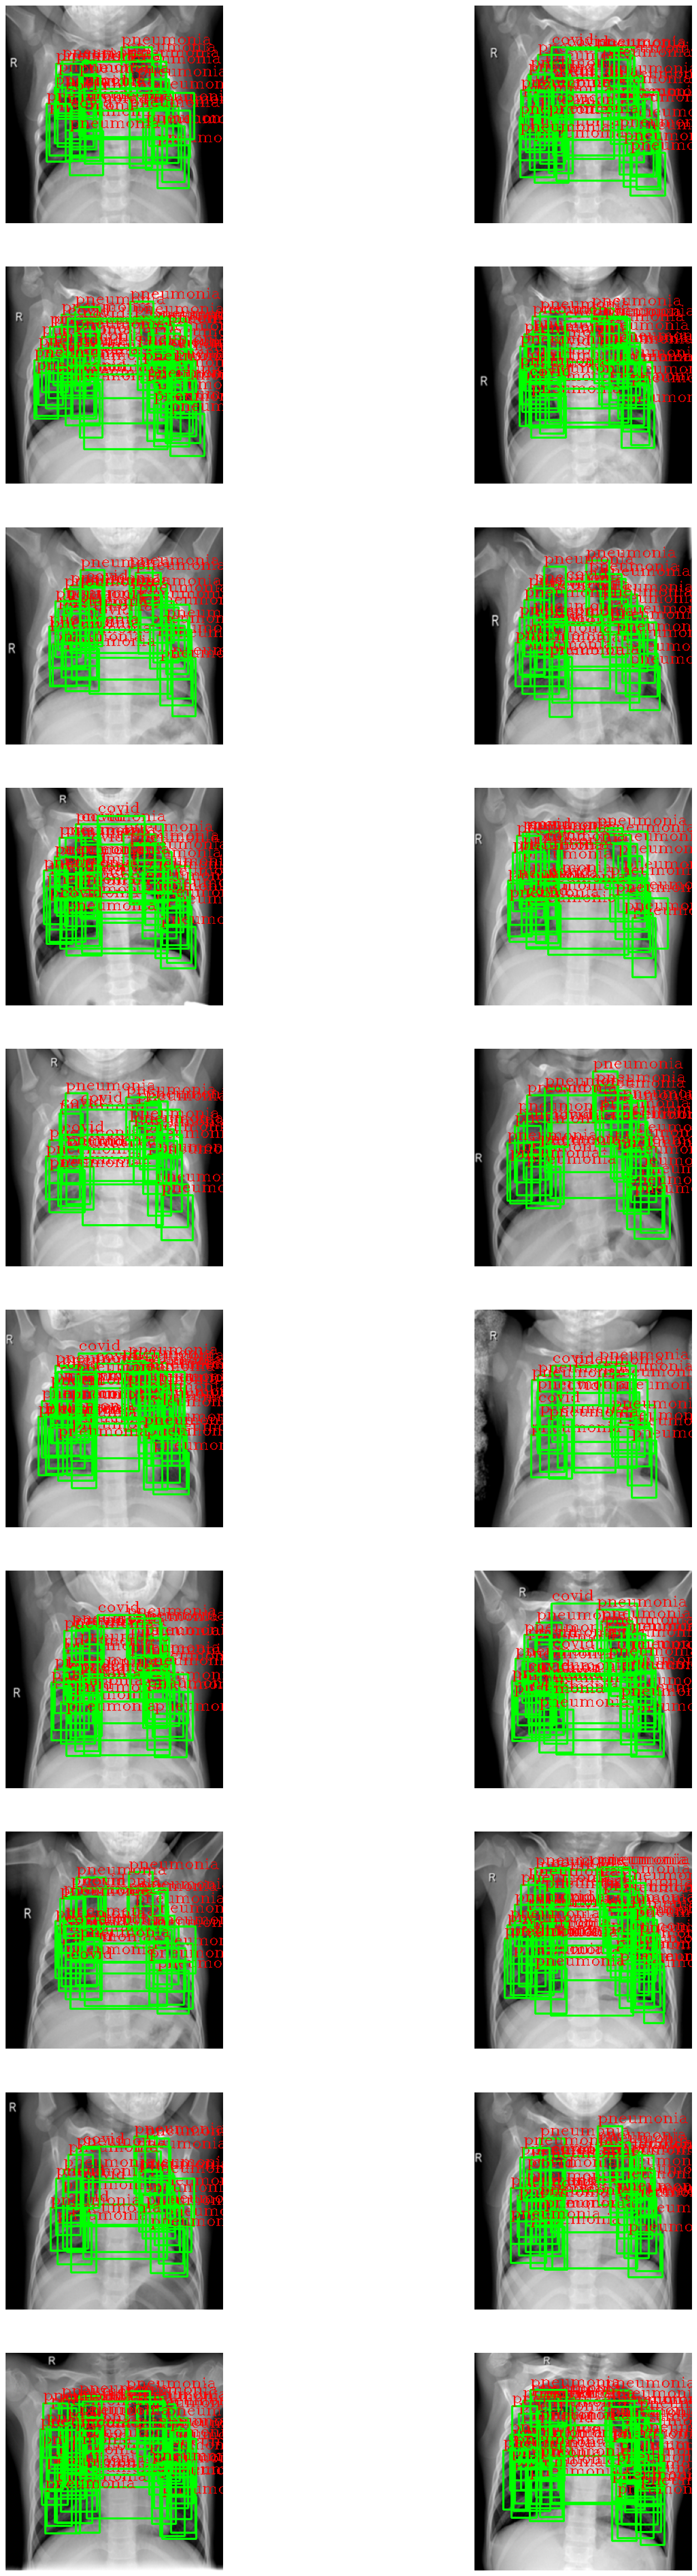

In [102]:
# pred_path = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/For Object Detection/NoBoxes'
pred_path = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/Test Data (300 images)'
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
#     plt.savefig('save_image.png', bbox_inches='tight')  # if you want to save result

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2]
[]
[[[0.6862745  0.6862745  0.6862745 ]
  [0.68235296 0.68235296 0.68235296]
  [0.6745098  0.6745098  0.6745098 ]
  ...
  [0.42352942 0.42352942 0.42352942]
  [0.42352942 0.42352942 0.42352942]
  [0.42352942 0.42352942 0.42352942]]

 [[0.68235296 0.68235296 0.68235296]
  [0.68235296 0.68235296 0.68235296]
  [0.6745098  0.6745098  0.6745098 ]
  ...
  [0.42352942 0.42352942 0.42352942]
  [0.42352942 0.42352942 0.42352942]
  [0.42352942 0.42352942 0.42352942]]

 [[0.68235296 0.68235296 0.68235296]
  [0.6784314  0.6784314  0.6784314 ]
  [0.6745098  0.6745098  0.6745098 ]
  ...
  [0.42745098 0.42745098 0.42745098]
  [0.42745098 0.42745098 0.42745098]
  [0.42745098 0.42745098 0.42745098]]

 ...



NameError: ignored

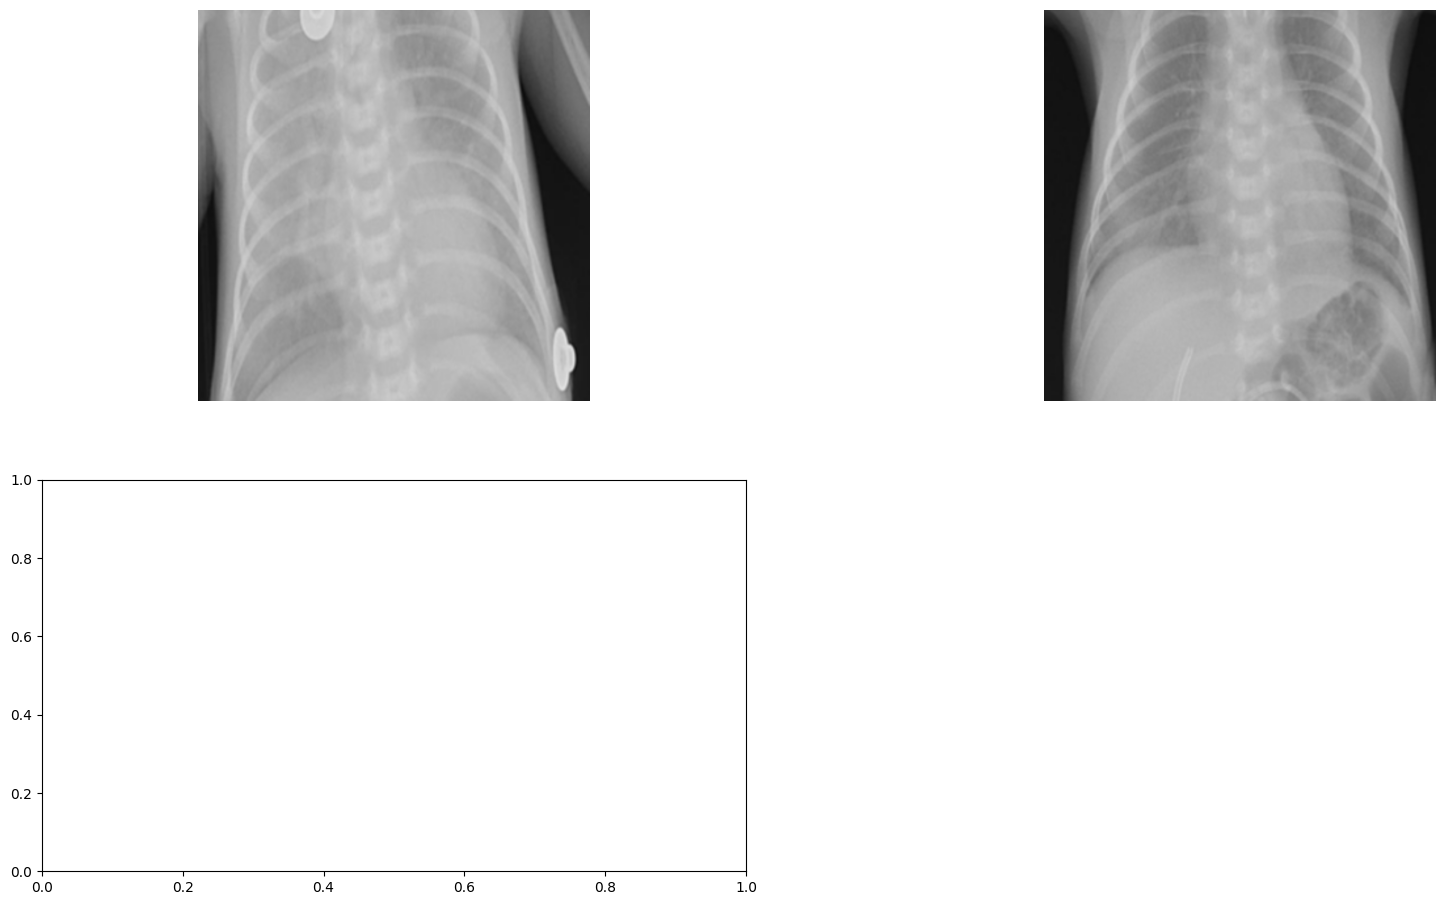

In [95]:
pred_path = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/For Object Detection/NoBoxes'
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

start = 1
plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i < start:
      pass
    elif i in range(start+1,start+10):
        plt.subplot(10,2,i-start)
        names,boxes,sample = obj_detector(images)
        print(names)
        print(boxes)
        print(sample)
        for i,box in enumerate(boxes):
            cv2.rectangle(sample,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0, 220, 0), 2)
            cv2.putText(sample, data.label_mapping[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

        plt.axis('off')
        plt.imshow(sample)